In [1]:
import pandas as pd
import json
import numpy as np
import os
from pathlib import Path
from bs4 import BeautifulSoup
import re
from collections import Counter
import nltk
import spacy

from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
from keybert import KeyBERT
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance

from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from nltk.corpus import stopwords

### loading data

In [2]:
processing = pd.read_csv('combined_posts_processing.csv')

C:\Users\Imaji Kasih\AppData\Local\Temp\ipykernel_2152\3681708014.py:1: DtypeWarning: Columns (51,63,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  processing = pd.read_csv('combined_posts_processing.csv')


In [3]:
cinder = pd.read_csv('combined_posts_cinder.csv')

In [4]:
post_dir = Path('./test_archive_openrndr/posts')
openrndr = []

for json_file in post_dir.glob('**/*.json'):
    with open(json_file, 'r') as f:
        post_data = json.load(f)
        openrndr.append(post_data)

openrndr = pd.DataFrame(openrndr)

In [5]:
columns_to_check = [51, 63, 65, 66]

# For each of these columns, show the unique data types and some sample values
for col in columns_to_check:
    print(f"\nColumn {col} - Unique data types and sample values:")
    print(processing.iloc[:, col].map(type).value_counts())
    print(processing.iloc[:, col].dropna().unique()[:10])  # Display up to 10 unique values


Column 51 - Unique data types and sample values:
akismet_state
<class 'float'>    95436
<class 'str'>         45
Name: count, dtype: int64
['confirmed_ham']

Column 63 - Unique data types and sample values:
locked
<class 'float'>    95460
<class 'bool'>        21
Name: count, dtype: int64
[True]

Column 65 - Unique data types and sample values:
polls
<class 'float'>    95480
<class 'str'>          1
Name: count, dtype: int64
["[{'id': 33, 'name': 'poll', 'type': 'multiple', 'status': 'open', 'public': True, 'results': 'on_vote', 'min': 1, 'max': 4, 'options': [{'id': '22bd5ae06616e65a714889ba854b129c', 'html': 'Design changes to the search bar'}, {'id': '6f26d59749f03b92207e3b103a79e204', 'html': 'A search bar on every page to enable redirection to any page of the website'}, {'id': '3754de17d8966eb49b9b87394a7773c3', 'html': 'A search suggest drop-down list'}, {'id': '4b7d2d051f4fc0f6224a4efc8c04f665', 'html': 'Other ideas (Please mention them in the comments below)'}], 'voters': 2, '

In [8]:
processing['akismet_state'] = processing['akismet_state'].fillna('').astype(str)

processing['locked'] = processing['locked'].fillna(False).astype(bool)
processing['locked'] = processing['locked'].infer_objects(copy=False)

processing['polls'] = processing['polls'].fillna('').astype(str)

processing['user_suspended'] = processing['user_suspended'].fillna(False).astype(bool)
processing['user_suspended'] = processing['user_suspended'].infer_objects(copy=False)

In [9]:
topics_by_cat_processing = pd.read_csv('topics_by_category_processing.csv')
topics_by_cat_openrndr = pd.read_csv('topics_by_category_openrndr.csv')
topics_by_cat_cinder = pd.read_csv('topics_by_category_cinder.csv')
# way less than the actual dataframes though

In [10]:
processing = pd.merge(processing, topics_by_cat_processing, left_on="id", right_on="topic_id", how="left")
cinder = pd.merge(cinder, topics_by_cat_cinder, left_on="id", right_on="topic_id", how="left")
openrndr = pd.merge(openrndr, topics_by_cat_openrndr, left_on="id", right_on="topic_id", how="left")

### common and unique columns

In [11]:
columns_processing = set(processing.columns)
columns_cinder = set(cinder.columns)
columns_openrndr = set(openrndr.columns)

common_columns_pc = columns_processing.intersection(columns_cinder)
common_columns_po = columns_processing.intersection(columns_openrndr)

unique_to_processingc = columns_processing - columns_cinder
unique_to_cinder = columns_cinder - columns_processing

unique_to_processingo = columns_processing - columns_openrndr
unique_to_openrndr = columns_openrndr - columns_processing

In [12]:
# with cinder
print("columns in common (processing x cinder):\n", common_columns_pc)
print("\ncolumns only in processing:\n", unique_to_processingc)
print("\ncolumns only in cinder:\n", unique_to_cinder)

columns in common (processing x cinder):
 {'can_see_hidden_post', 'link_counts', 'user_id', 'topic_accepted_answer', 'version', 'flair_group_id', 'category', 'read', 'can_wiki', 'moderator', 'deleted_at', 'trust_level', 'id', 'can_unaccept_answer', 'can_edit', 'yours', 'topic_id_x', 'bookmarked', 'can_recover', 'accepted_answer', 'can_accept_answer', 'can_delete', 'wiki', 'cooked', 'name', 'topic_slug', 'quote_count', 'can_view_edit_history', 'topic_id_y', 'username', 'score', 'primary_group_name', 'readers_count', 'avatar_template', 'updated_at', 'reply_to_post_number', 'edit_reason', 'post_type', 'post_number', 'reads', 'created_at', 'via_email', 'user_deleted', 'actions_summary', 'flair_color', 'polls', 'incoming_link_count', 'display_username', 'flair_url', 'flair_bg_color', 'hidden', 'title_is_group', 'flair_name', 'reply_count', 'staff', 'reply_to_user', 'admin', 'user_title'}

columns only in processing:
 {'user_cakedate', 'user_suspended', 'user_birthdate', 'reviewable_score_co

In [13]:
# with openrndr
print("columns in common (processing x openrndr):\n", common_columns_po)
print("\ncolumns only in processing:\n", unique_to_processingc)
print("\ncolumns only in openrndr:\n", unique_to_openrndr)

columns in common (processing x openrndr):
 {'can_see_hidden_post', 'user_id', 'topic_accepted_answer', 'version', 'flair_group_id', 'category', 'can_wiki', 'moderator', 'deleted_at', 'trust_level', 'id', 'can_unaccept_answer', 'can_edit', 'yours', 'topic_id_x', 'bookmarked', 'can_recover', 'accepted_answer', 'can_accept_answer', 'can_delete', 'wiki', 'cooked', 'name', 'topic_slug', 'quote_count', 'can_view_edit_history', 'topic_id_y', 'username', 'score', 'primary_group_name', 'readers_count', 'avatar_template', 'updated_at', 'reply_to_post_number', 'edit_reason', 'post_type', 'post_number', 'reads', 'created_at', 'via_email', 'user_deleted', 'actions_summary', 'flair_color', 'polls', 'incoming_link_count', 'display_username', 'flair_url', 'flair_bg_color', 'hidden', 'flair_name', 'reply_count', 'staff', 'reply_to_user', 'admin', 'user_title'}

columns only in processing:
 {'user_cakedate', 'user_suspended', 'user_birthdate', 'reviewable_score_count', 'reviewable_score_pending_count',

### dropping unused columns

In [14]:
processing = processing.drop(['avatar_template', 'yours', 'display_username', 
                              'flair_name', 'flair_url', 'flair_bg_color', 'flair_color', 
                              'flair_group_id', 'can_edit', 'can_delete', 'can_recover',
                              'can_see_hidden_post', 'can_wiki', 'bookmarked', 'moderator',
                              'admin', 'staff', 'can_view_edit_history', 'via_email',
                              'user_birthdate', 'user_cakedate'], 
                              axis=1)

openrndr = openrndr.drop(['avatar_template', 'yours', 'topic_html_title', 'display_username', 
                          'flair_name', 'flair_url', 'flair_bg_color', 'flair_color', 
                          'flair_group_id', 'can_edit', 'can_delete', 'can_recover',
                          'can_see_hidden_post', 'can_wiki', 'bookmarked', 'moderator',
                          'admin', 'staff', 'can_view_edit_history', 'wiki', 'reactions', 
                          'current_user_reaction', 'current_user_used_main_reaction', 'via_email'], 
                          axis=1)

cinder = cinder.drop(['avatar_template', 'yours', 'display_username', 
                      'flair_name', 'flair_url', 'flair_bg_color', 'flair_color', 
                      'flair_group_id', 'can_edit', 'can_delete', 'can_recover',
                      'can_see_hidden_post', 'can_wiki', 'bookmarked', 'moderator',
                      'admin', 'staff', 'can_view_edit_history', 'via_email'], 
                      axis=1)

### formatting dates and visualize number of posts over time

In [15]:
processing['created_at'] = pd.to_datetime(processing['created_at'])
processing['updated_at'] = pd.to_datetime(processing['updated_at']) 

cinder['created_at'] = pd.to_datetime(cinder['created_at'])
cinder['updated_at'] = pd.to_datetime(cinder['updated_at']) 

openrndr['created_at'] = pd.to_datetime(openrndr['created_at'])
openrndr['updated_at'] = pd.to_datetime(openrndr['updated_at']) 

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

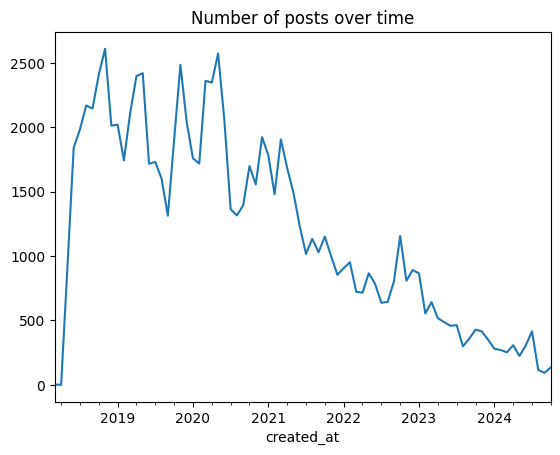

In [17]:
processing.set_index('created_at').resample('ME').size().plot(title='Number of posts over time')

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

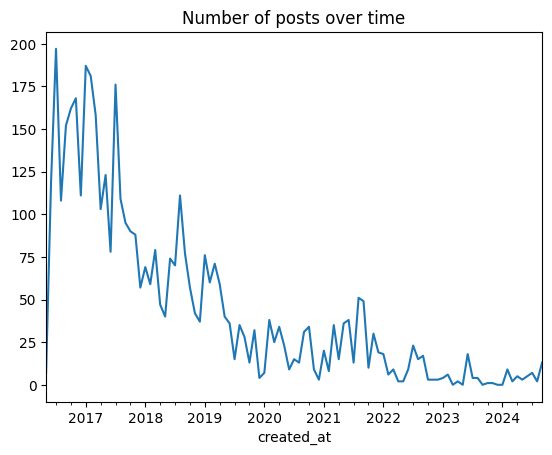

In [18]:
cinder.set_index('created_at').resample('ME').size().plot(title='Number of posts over time')

<Axes: title={'center': 'Number of posts over time'}, xlabel='created_at'>

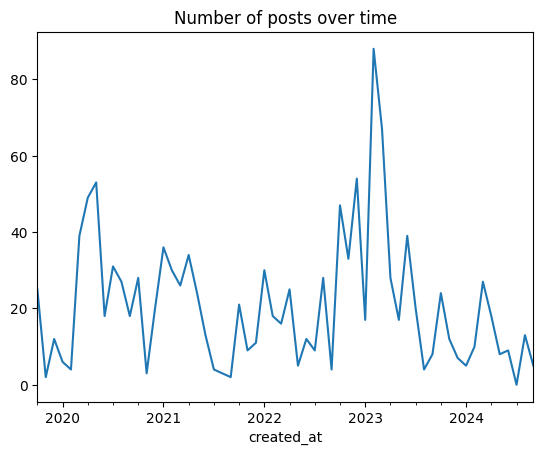

In [19]:
openrndr.set_index('created_at').resample('ME').size().plot(title='Number of posts over time')

### inspecting 'cooked'

In [20]:
processing['cooked'].head()

0    <p>Hi, my name is Byambaa, and I am interested...
1    <p>I made a simple tile game in 2 in two dimen...
2    <p>post a mcve</p>\n<aside class="onebox white...
3    <p>in practice I create the tile passing them ...
4    <p>2d the same main:<br>\n<div class="lightbox...
Name: cooked, dtype: object

In [21]:
openrndr['cooked'].head()

0    <p>Discussion about this site, its organizatio...
1    <p>OPENRNDR is an opensource framework for cre...
2    <p>I guess “Site Feedback” is the “Meta” categ...
3    <p>I don’t know how much we can change on the ...
4    <p><code>How to?</code> sounds OK,  or the bit...
Name: cooked, dtype: object

In [22]:
cinder['cooked'].head()

0    <p>Hi all,</p>\n<p>I´m about to start a VR vid...
1    <p>mayve you can use opencv ? i have very rece...
2    <p>Hello,<br>\nVery interesting !<br>\nAre you...
3    <p>Just this past weekend did tons of 4k video...
4    <p>Hi <a class="mention" href="/u/colin">@coli...
Name: cooked, dtype: object

### cleaning cooked

In [23]:
processing['cooked'] = processing['cooked'].fillna('')

In [24]:
'''
# Function to find all tags in a single post
def find_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return [tag.name for tag in soup.find_all()]
'''

'\n# Function to find all tags in a single post\ndef find_tags(text):\n    soup = BeautifulSoup(text, "html.parser")\n    return [tag.name for tag in soup.find_all()]\n'

In [25]:
'''
all_tags_processing = processing['cooked'].apply(find_tags).sum()
tag_counts_processing = Counter(all_tags_processing)
print("Unique HTML tags present and their counts:")
print(tag_counts_processing)
'''

'\nall_tags_processing = processing[\'cooked\'].apply(find_tags).sum()\ntag_counts_processing = Counter(all_tags_processing)\nprint("Unique HTML tags present and their counts:")\nprint(tag_counts_processing)\n'

In [26]:
# Function to extract content of specific tages
def extract_tag_content(row):
    soup = BeautifulSoup(row, "html.parser")

    code_content = " ".join([tag.get_text() for tag in soup.find_all('code')])
    a_content = " ".join([tag.get_text() for tag in soup.find_all('a')])
    iframe_content = " ".join([tag.get_text() for tag in soup.find_all('iframe')])

    return pd.Series({
        'code_content': code_content,
        'a_content': a_content,
        'iframe_content': iframe_content
    })

In [27]:
processing[['code_content', 'a_content', 'iframe_content']] = processing['cooked'].apply(extract_tag_content)
cinder[['code_content', 'a_content', 'iframe_content']] = cinder['cooked'].apply(extract_tag_content)
openrndr[['code_content', 'a_content', 'iframe_content']] = openrndr['cooked'].apply(extract_tag_content)
# maybe remove iframe

In [28]:
# Function to remove content of certain tags
def clean_cooked_tag_content(row):
    soup = BeautifulSoup(row, "html.parser")
    for tag in soup.find_all(['code', 'a', 'iframe', 'img', 'svg', 'source', 'video', 'track', 'sub']):
        tag.decompose()
    
    return str(soup)

In [29]:
processing['cooked_cleaned'] = processing['cooked'].apply(clean_cooked_tag_content)
cinder['cooked_cleaned'] = cinder['cooked'].apply(clean_cooked_tag_content)
openrndr['cooked_cleaned'] = openrndr['cooked'].apply(clean_cooked_tag_content)

In [30]:
# Function to clean HTML tags
def clean_html_tags(text):
    # Parse the HTML content
    soup = BeautifulSoup(text, "html.parser")
    # Get plain text without HTML tags
    clean_text = soup.get_text()
    # Remove extra whitespace, newline characters, etc.
    clean_text = re.sub(r'\s+', ' ', clean_text).strip()
    return clean_text

In [31]:
processing['cooked_html_cleaned'] = processing['cooked_cleaned'].apply(clean_html_tags)
cinder['cooked_html_cleaned'] = cinder['cooked_cleaned'].apply(clean_html_tags)
openrndr['cooked_html_cleaned'] = openrndr['cooked_cleaned'].apply(clean_html_tags)

### text preprocessing

In [33]:
processing['year'] = processing['created_at'].dt.year
cinder['year'] = cinder['created_at'].dt.year
openrndr['year'] = openrndr['created_at'].dt.year

In [277]:
# Load the spaCy model (make sure it's installed first with: pip install spacy && python -m spacy download en_core_web_sm)
nlp = spacy.load('en_core_web_sm')

# Define additional stopwords
additional_stop_words = {'hi', 'hello', 'sorry', 'thanks', 'thank', 'thank you', 'thankyou', 'guys', 'ok', 'okay'} # should 'like' be added?

# Update spaCy's stopword list with your additional stopwords
for word in additional_stop_words:
    nlp.vocab[word].is_stop = True

In [278]:
# Function to preprocess text using spaCy
def preprocess_text_spacy(text):
    # Process text with spaCy
    doc = nlp(text)
    
    # Tokenize, remove stopwords, and non-alphabetic tokens (i.e., numbers and punctuation)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    
    # Join the tokens back into a single string
    return ' '.join(tokens)

In [279]:
processing['processed_text'] = processing['cooked_html_cleaned'].apply(preprocess_text_spacy)
cinder['processed_text'] = cinder['cooked_html_cleaned'].apply(preprocess_text_spacy)
openrndr['processed_text'] = openrndr['cooked_html_cleaned'].apply(preprocess_text_spacy)

### generating embeddings (sentence transformer - all-MiniLM)

In [59]:
# generating embeddings

# using sentence transformer
model = SentenceTransformer('all-MiniLM-L6-v2') # look into other models
sentence_embeddings_p = []
sentence_embeddings_c = []
sentence_embeddings_o = []
batch_size = 512

In [ ]:
for i in range(0, len(processing), 512):
    batch_texts = processing['processed_text'][i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=True)
    sentence_embeddings_p.extend(batch_embeddings)

In [60]:
for i in range(0, len(cinder), 512):
    batch_texts = cinder['processed_text'][i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=True)
    sentence_embeddings_c.extend(batch_embeddings)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [61]:
for i in range(0, len(openrndr), 512):
    batch_texts = openrndr['processed_text'][i:i+batch_size].tolist()
    batch_embeddings = model.encode(batch_texts, show_progress_bar=True)
    sentence_embeddings_o.extend(batch_embeddings)

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/8 [00:00<?, ?it/s]

In [62]:
cinder['sentence_embeddings'] = sentence_embeddings_c
openrndr['sentence_embeddings'] = sentence_embeddings_o
processing['specter2_embeddings'] = sentence_embeddings_p

### generating embeddings (sentence transformer - specter2)

In [231]:
from adapters import AutoAdapterModel
from transformers import AutoTokenizer
import torch

In [232]:
# loading model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('allenai/specter2_base')

# load base model
specter2 = AutoAdapterModel.from_pretrained("allenai/specter2_base")
# load the adapter(2) as per the required task, provide an identifier for the adapter in load_as argument and activate it
specter2.load_adapter("allenai/specter2", source="hf", load_as="specter2", set_active=True)

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

'specter2'

In [234]:
cinder['specter_tokens_length'] = cinder['cooked_html_cleaned'].apply(lambda x: len(tokenizer.tokenize(str(x))))
openrndr['specter_tokens_length'] = openrndr['cooked_html_cleaned'].apply(lambda x: len(tokenizer.tokenize(str(x))))
processing['specter_tokens_length'] = processing['cooked_html_cleaned'].apply(lambda x: len(tokenizer.tokenize(str(x))))

In [235]:
print('Cinder tokens length')
print(cinder['specter_tokens_length'].describe())

print('OpenRNDR tokens length')
print(openrndr['specter_tokens_length'].describe())

print('Processing tokens length')
print(processing['specter_tokens_length'].describe())

Cinder tokens length
count    4461.000000
mean      108.479937
std       122.972442
min         0.000000
25%        36.000000
50%        74.000000
75%       139.000000
max      2446.000000
Name: specter_tokens_length, dtype: float64
OpenRNDR tokens length
count    1255.000000
mean       86.886853
std        98.907598
min         0.000000
25%        29.000000
50%        57.000000
75%       111.000000
max      1560.000000
Name: specter_tokens_length, dtype: float64
Processing tokens length
count    95483.000000
mean        87.149294
std        165.264272
min          0.000000
25%         25.000000
50%         55.000000
75%        106.000000
max      12503.000000
Name: specter_tokens_length, dtype: float64


In [ ]:
cinder['specter_tokens_length'].quantile(0.99) #571
openrndr['specter_tokens_length'].quantile(0.99) # 459.9
processing['specter_tokens_length'].quantile(0.99) # 513

In [236]:
def combine_topic_and_text(df):
    """
    combines topic_slug and cooked_html_cleaned columns into a single text column

    parameters:
    - df (pd.DataFrame): the input dataframe

    returns:
    - combined_text (list): list of combined text for each row 
    """
    # replace dashes in topic_slug with spaces
    df['topic_slug'] = df['topic_slug'].str.replace('-', ' ')

    # combine topic_slug and cooked_html_cleaned into one string per row
    combined_text = [
        row['topic_slug'] + tokenizer.sep_token + (row['processed_text'] or '') # was originally cooked_html_cleaned
        for _, row in df.iterrows()
    ]

    return combined_text

In [237]:
def tokenize_for_specter(text_batch):
    """
    tokenizes a batch of texts using the tokenizer

    parameters:
    - text_batch (list): list of texts to tokenize

    returns:
    - inputs (dict): tokenized inputs for the model
    """

    inputs = tokenizer(
        text_batch,
        padding=True,
        truncation=True,
        return_tensors="pt",
        return_token_type_ids=False,
        max_length=512
    )
    return inputs

In [238]:
def compute_specter2_embeddings(inputs):
    """
    computes embeddings for the tokenized inputs

    parameters:
    - inputs (dict): tokenized inputs for the model

    returns:
    - embeddings (numpy.ndarray): array of embeddings for the input  texts
    """

    with torch.no_grad():
        output = specter2(**inputs)

    # take the first token in the batch as the embedding (CLS token)
    embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

In [239]:
def main_specter2(dataframe, batch_size=128):
    """
    Main function to compute Specter2 embeddings for each row in the dataframe.
    
    Parameters:
    - dataframe (pd.DataFrame): The input dataframe.
    - batch_size (int): The number of rows to process at a time.
    
    Returns:
    - embeddings (list): List of embeddings for all valid rows.
    """
    embeddings = []
    processed_texts = combine_topic_and_text(dataframe)  # Step 1: Preprocess data
    
    total_batches = len(dataframe) // batch_size + int(len(dataframe) % batch_size > 0)

    for i in range(0, len(dataframe), batch_size):
        # Prepare the batch (subset of dataframe)
        batch_texts = processed_texts[i:i + batch_size]

        # Step 2: Tokenize the current batch
        inputs = tokenize_for_specter(batch_texts)

        # Step 3: Compute embeddings for the current batch
        batch_embeddings = compute_specter2_embeddings(inputs)

        embeddings.extend(batch_embeddings)
        print(f"Processed batch {i // batch_size + 1}/{total_batches}")
    
    return embeddings

In [240]:
specter_emb_c = main_specter2(cinder)

Processed batch 1/35
Processed batch 2/35
Processed batch 3/35
Processed batch 4/35
Processed batch 5/35
Processed batch 6/35
Processed batch 7/35
Processed batch 8/35
Processed batch 9/35
Processed batch 10/35
Processed batch 11/35
Processed batch 12/35
Processed batch 13/35
Processed batch 14/35
Processed batch 15/35
Processed batch 16/35
Processed batch 17/35
Processed batch 18/35
Processed batch 19/35
Processed batch 20/35
Processed batch 21/35
Processed batch 22/35
Processed batch 23/35
Processed batch 24/35
Processed batch 25/35
Processed batch 26/35
Processed batch 27/35
Processed batch 28/35
Processed batch 29/35
Processed batch 30/35
Processed batch 31/35
Processed batch 32/35
Processed batch 33/35
Processed batch 34/35
Processed batch 35/35


In [241]:
specter_emb_o = main_specter2(openrndr)

Processed batch 1/10
Processed batch 2/10
Processed batch 3/10
Processed batch 4/10
Processed batch 5/10
Processed batch 6/10
Processed batch 7/10
Processed batch 8/10
Processed batch 9/10
Processed batch 10/10


In [ ]:
specter_emb_p = main_specter2(processing)

In [242]:
cinder['specter2_embeddings'] = specter_emb_c
openrndr['specter2_embeddings'] = specter_emb_o
#processing['specter2_embeddings'] = specter_emb_p

### UMAP document embedding

In [243]:
from umap import UMAP

In [244]:
# function to apply the umap model
def apply_umap(embeddings, metric='cosine', n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    """
    Applies UMAP dimensionality reduction to the given embeddings

    Parameters:
    embeddings (array-like): The input embeddings to reduce 
    n_neighbors (int): Number of neighbors for UMAP
    metric (str): Distance metric UMAP uses to measure similarity between points
    min_dist (float): Minimum distance between points in low-dimensional space
    n_components (int): Number of output dimensions
    random_state (int): Random state for reproducibility

    Returns:
    np.ndarray: UMAP-transformed embeddings
    """

    umap_model = UMAP(
        metric=metric, # 'euclidean' works well for man embeddings, 'cosine' often works well with text embeddings - focusing more on angle than magnitude
        n_neighbors=n_neighbors, # determines balance between local and global structure | higher values = capture more global structure
        min_dist=min_dist, # controls minimum distance between points (range 0-1) | lower values pack points more tightly, highlight distinct clusters, may cause overlap
        n_components=n_components, # number of dimensions for the UMAP output
        random_state=random_state
    )

    # converting the embeddings to a 2D numpy array
    embeddings = np.array(embeddings)

    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_model, umap_embeddings

In [ ]:
'''
n_neighbors
- larger = more global structure, more points are shown, how points are connected
- smaller = more local structure
*try to make the value smaller for processing

min_dist
- how tightly UMAP is allowed to pack points together
- smaller value = clumpier embeddings, detailed topological structure
- larger value = broader topological structure
*try to make value larger for processing 
* initial idea was that we want this to be smaller because we want to cluster
'''

In [245]:
umap_model_c, umap_cinder = apply_umap(specter_emb_c, n_neighbors=30)
umap_model_o, umap_openrndr = apply_umap(specter_emb_o)
#umap_model_p, umap_processing = apply_umap(specter_emb_p)

In [63]:
umap_model_c_2, umap_cinder_2 = apply_umap(sentence_embeddings_c)
umap_model_o_2, umap_openrndr_2 = apply_umap(sentence_embeddings_o)
#umap_model_p_2, umap_processing_2 = apply_umap(sentence_embeddings_p)

In [246]:
#umap_df_p = pd.DataFrame(umap_processing, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
umap_df_c = pd.DataFrame(umap_cinder, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
umap_df_o = pd.DataFrame(umap_openrndr, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
umap_df_c_2 = pd.DataFrame(umap_cinder_2, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
umap_df_o_2 = pd.DataFrame(umap_openrndr_2, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])

In [247]:
cinder['UMAP Dimension 1'] = umap_df_c['UMAP Dimension 1']
cinder['UMAP Dimension 2'] = umap_df_c['UMAP Dimension 2']

In [248]:
cinder['UMAP Dimension 1 (2)'] = umap_df_c_2['UMAP Dimension 1']
cinder['UMAP Dimension 2 (2)'] = umap_df_c_2['UMAP Dimension 2']

In [249]:
openrndr['UMAP Dimension 1'] = umap_df_o['UMAP Dimension 1']
openrndr['UMAP Dimension 2'] = umap_df_o['UMAP Dimension 2']

In [250]:
openrndr['UMAP Dimension 1 (2)'] = umap_df_o_2['UMAP Dimension 1']
openrndr['UMAP Dimension 2 (2)'] = umap_df_o_2['UMAP Dimension 2']

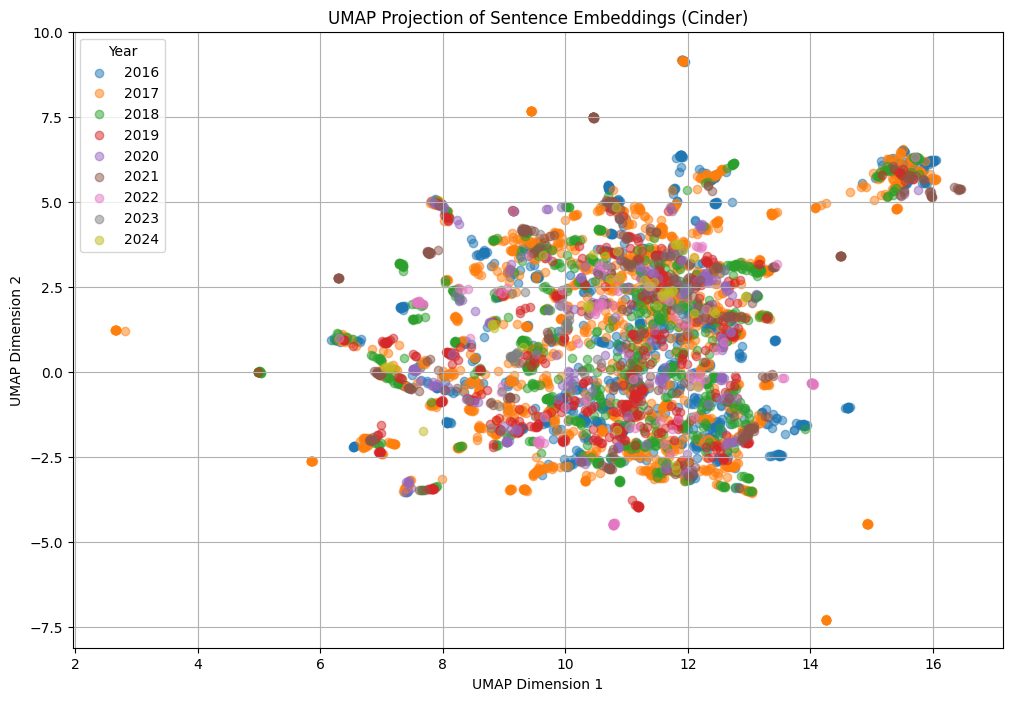

In [251]:
plt.figure(figsize=(12,8))
unique_years_cinder = cinder['year'].unique()
for year in unique_years_cinder:
    subset = cinder[cinder['year'] == year]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(year), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Cinder)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Year')
plt.grid()
plt.show()

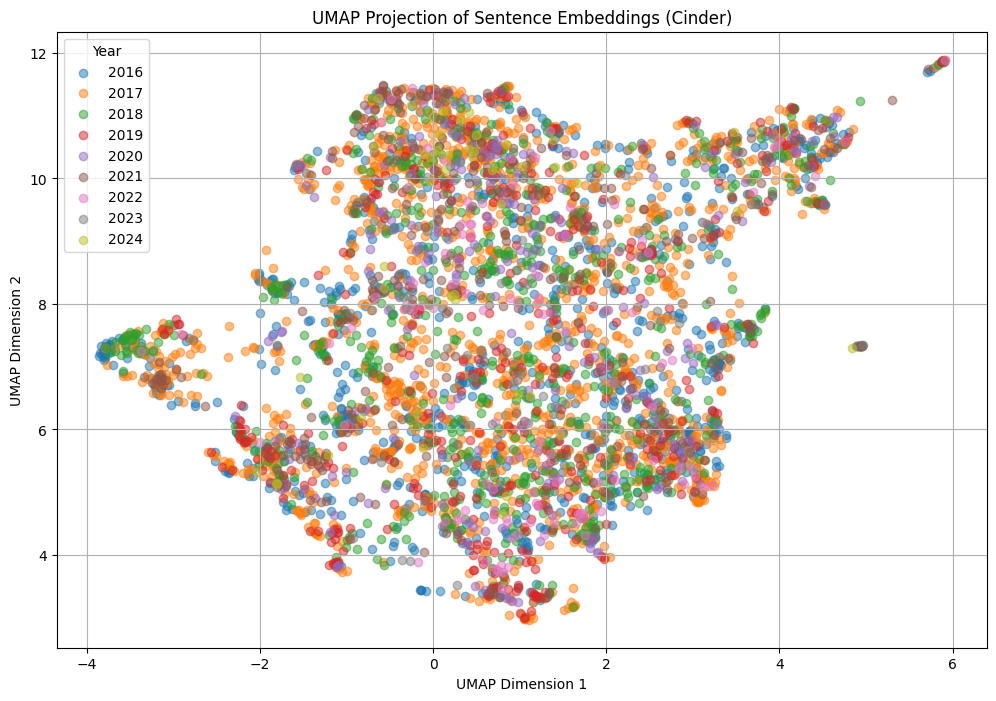

In [252]:
plt.figure(figsize=(12,8))
unique_years_cinder = cinder['year'].unique()
for year in unique_years_cinder:
    subset = cinder[cinder['year'] == year]
    plt.scatter(subset['UMAP Dimension 1 (2)'], subset['UMAP Dimension 2 (2)'],
                label=str(year), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Cinder)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Year')
plt.grid()
plt.show()

In [253]:
import seaborn as sns

# Generate a unique color for each category
unique_cat_openrndr = openrndr['category_id'].unique()
color_palette = sns.color_palette("magma", len(unique_cat_openrndr))
color_mapping = {cat: color_palette[i] for i, cat in enumerate(unique_cat_openrndr)}


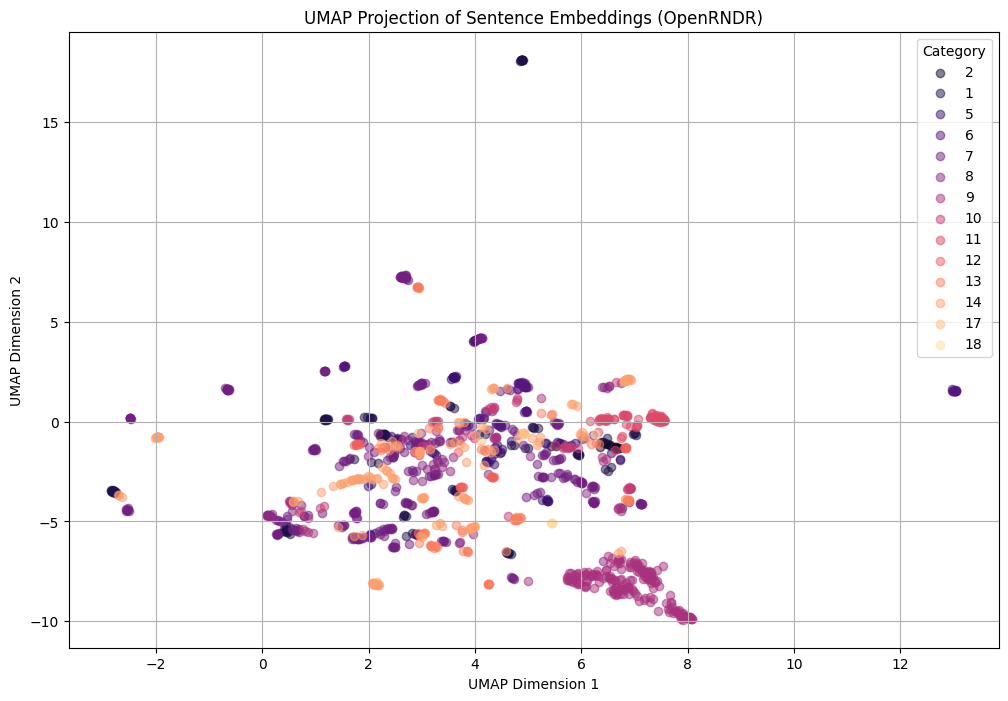

In [254]:
plt.figure(figsize=(12,8))

for cat in unique_cat_openrndr:
    subset = openrndr[openrndr['category_id'] == cat]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(cat), alpha=0.5, color=color_mapping[cat])

plt.title('UMAP Projection of Sentence Embeddings (OpenRNDR)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Category')
plt.grid()
plt.show()

### testing umap parameters

In [38]:
def test_umap_parameters(embeddings, data, n_neighbors_values, min_dist_values, metric='cosine', random_state=42):
    """
    Tests different UMAP parameters and visualizes the results.

    Parameters:
    embeddings (array-like): The input embeddings to reduce.
    data (pd.DataFrame): Dataframe containing additional information (e.g., 'year') for coloring.
    n_neighbors_values (list): List of values for n_neighbors to test.
    min_dist_values (list): List of values for min_dist to test.
    metric (str): Distance metric for UMAP.
    random_state (int): Random state for reproducibility.
    """
    plt.figure(figsize=(18, 12))
    plot_index = 1

    for n_neighbors in n_neighbors_values:
        for min_dist in min_dist_values:
            # Apply UMAP with current parameters
            umap_embeddings = apply_umap(
                embeddings, 
                n_neighbors=n_neighbors, 
                min_dist=min_dist, 
                metric=metric, 
                random_state=random_state
            )
            umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
            umap_df['year'] = data['year']
            
            # Plot the results
            plt.subplot(len(n_neighbors_values), len(min_dist_values), plot_index)
            unique_years = umap_df['year'].unique()
            for year in unique_years:
                subset = umap_df[umap_df['year'] == year]
                plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'], label=str(year), alpha=0.5)
            
            plt.title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
            plt.xlabel('UMAP Dimension 1')
            plt.ylabel('UMAP Dimension 2')
            plt.xticks([])
            plt.yticks([])
            plot_index += 1
    
    plt.tight_layout()
    plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

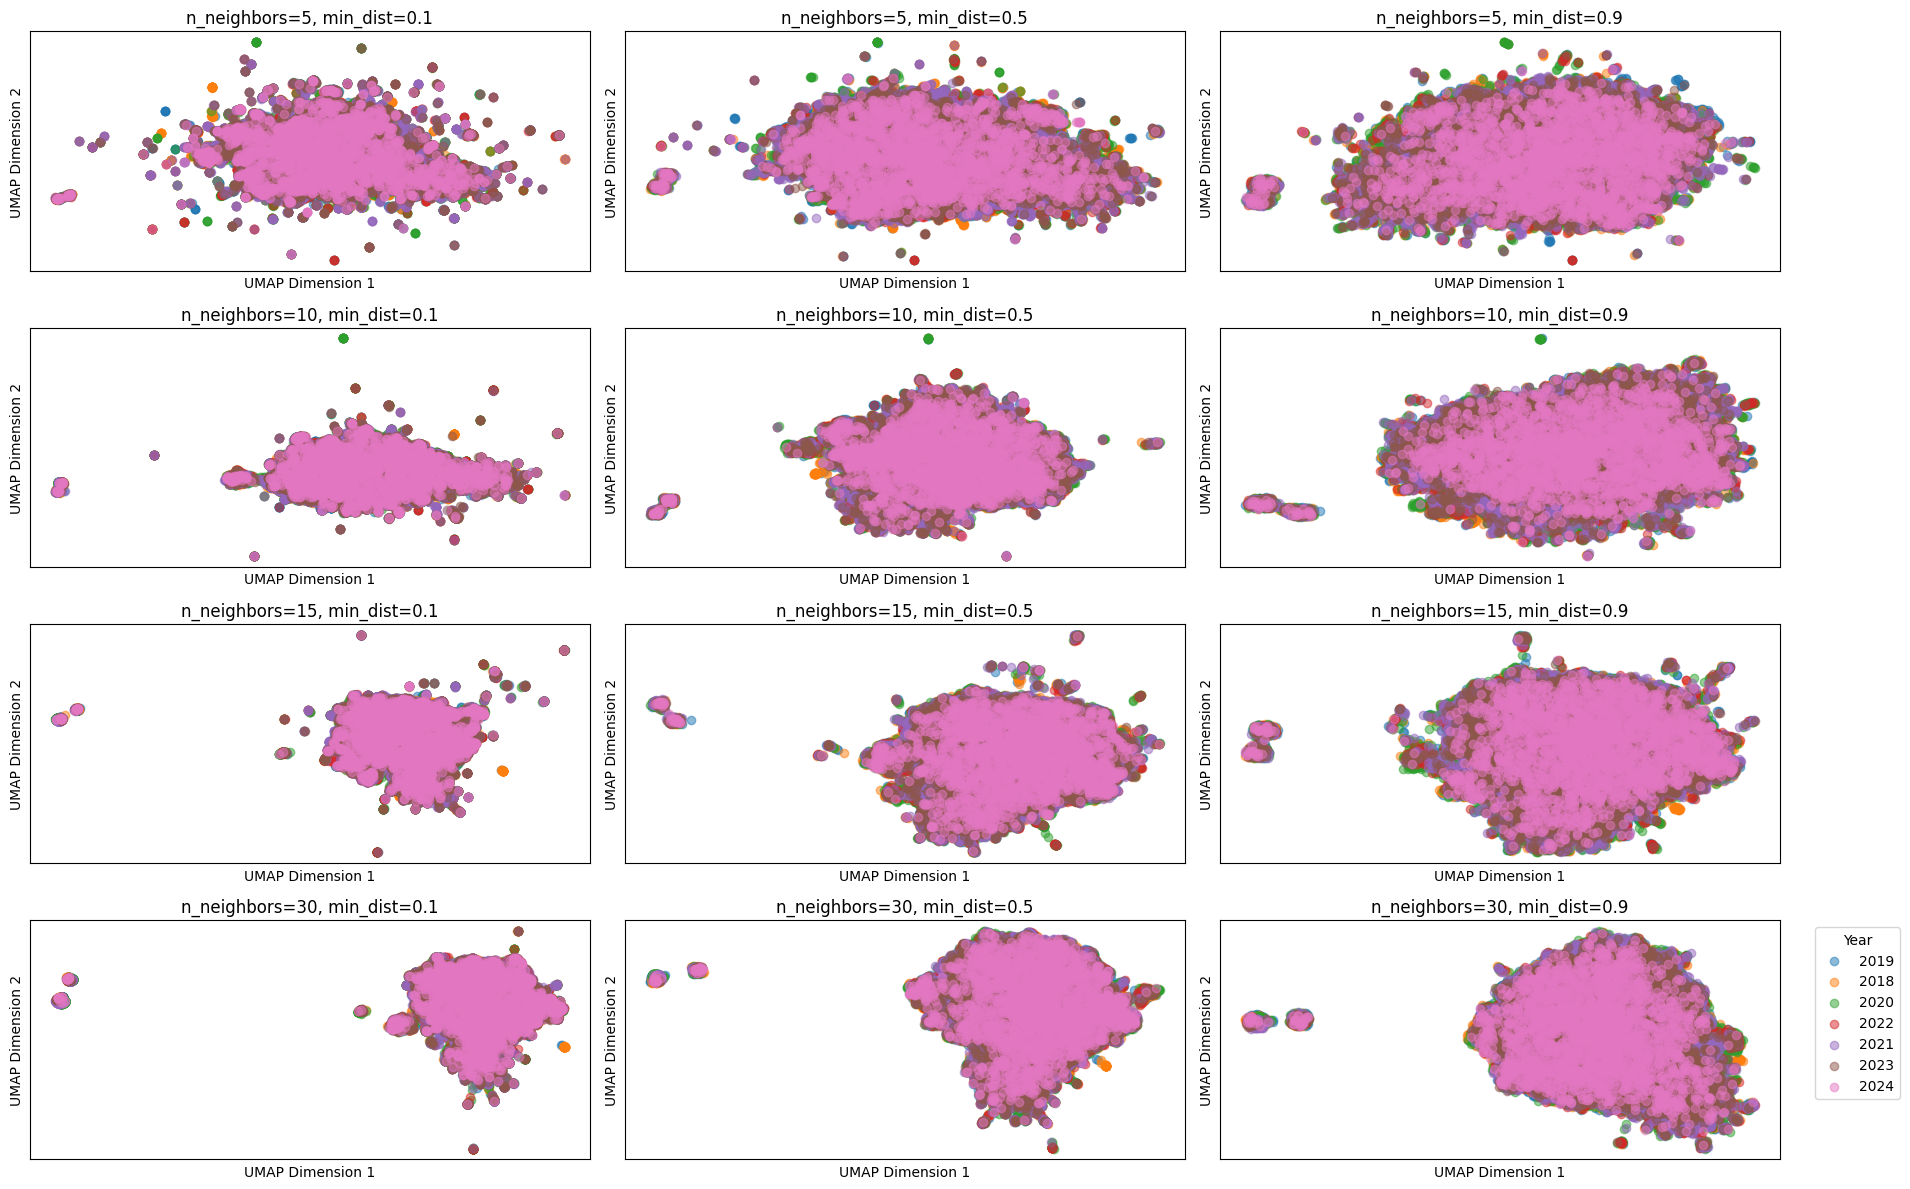

In [70]:
n_neighbors_values = [5, 10, 15, 30]  # Test different n_neighbors
min_dist_values = [0.1, 0.5, 0.9]  # Test different min_dist

test_umap_parameters(
    embeddings=sentence_embeddings_p,
    data=processing,
    n_neighbors_values=n_neighbors_values,
    min_dist_values=min_dist_values
)

In [37]:
def umap_parameters(embeddings, data, 
                    n_neighbors=15, min_dist=0.1, spread=1.0, 
                    repulsion_strength=1.0, learning_rate=1.0, 
                    metric='euclidean', densmap=False, set_op_mix_ratio=1.0, random_state=42):
    """
    Applies UMAP with adjustable parameters and visualizes the results.

    Parameters:
    embeddings (array-like): The input embeddings to reduce.
    data (pd.DataFrame): Dataframe containing additional information for coloring (e.g., 'year').
    n_neighbors (int): Number of neighbors for UMAP.
    min_dist (float): Minimum distance between points in low-dimensional space.
    spread (float): Scale of the embedding; larger values spread points out more.
    repulsion_strength (float): Strength of point repulsion in low-dimensional space.
    learning_rate (float): Rate at which embedding adapts during optimization.
    metric (str): Distance metric used by UMAP.
    densmap (bool): Whether to use DensMAP for density-adjusted embeddings.
    random_state (int): Random state for reproducibility.

    Returns:
    pd.DataFrame: UMAP-transformed data with dimensions and metadata.
    """
    # Apply UMAP with specified parameters
    umap_model = UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        spread=spread,
        repulsion_strength=repulsion_strength,
        learning_rate=learning_rate,
        metric=metric,
        densmap=densmap,
        set_op_mix_ratio=set_op_mix_ratio,
        random_state=random_state
    )
    
    embeddings = np.array(embeddings)
    umap_embeddings = umap_model.fit_transform(embeddings)
    
    # Create a DataFrame for visualization
    umap_df = pd.DataFrame(umap_embeddings, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])
    umap_df['year'] = data['year']
    
    # Plot the results
    plt.figure(figsize=(10, 7))
    unique_years = umap_df['year'].unique()
    for year in unique_years:
        subset = umap_df[umap_df['year'] == year]
        plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'], label=str(year), alpha=0.7)
    
    plt.title(f'UMAP Projection (n_neighbors={n_neighbors}, min_dist={min_dist}, spread={spread})')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.legend(title='Year', loc='best')
    plt.grid()
    plt.show()
    
    return umap_df

`min_dist`
Effect: Controls how tightly UMAP packs points in the low-dimensional space.
How to adjust: Increase min_dist (e.g., from 0.1 to 0.5 or higher). This will increase the spacing between clusters and spread out the points more.

`spread`
Effect: Determines the scale of the embedding; larger values spread points out more.
How to adjust: Increase spread (e.g., from 1.0 to 2.0 or higher).

`n_neighbors`
Effect: Determines the balance between local and global structure.
How to adjust: Decrease n_neighbors to focus more on local relationships (e.g., from 15 to 5), which can sometimes make clusters more distinct.

`repulsion_strength`
Effect: Controls how strongly points are pushed apart in the low-dimensional space.
How to adjust: Increase repulsion_strength (e.g., from 1.0 to 2.0 or higher). This makes the visualization more dispersed overall.

`learning_rate`
Effect: Controls the rate at which the embedding adapts during optimization.
How to adjust: Increase learning_rate (e.g., from 1.0 to 10.0), which can speed up convergence to a dispersed state.

`densmap` (if using DensMAP, a variation of UMAP):
Effect: Helps adjust for density variation in the data, creating more interpretable and dispersed embeddings.
How to adjust: Set densmap=True and tweak dens_lambda (controls importance of density), dens_frac, and dens_var_shift.

`set_op_mix_ratio`
Effect: Balances the use of mutual nearest neighbors to construct the graph.
How to adjust: Lowering this value (e.g., from 1.0 to 0.5) can focus more on local neighbors, sometimes leading to a more dispersed layout.

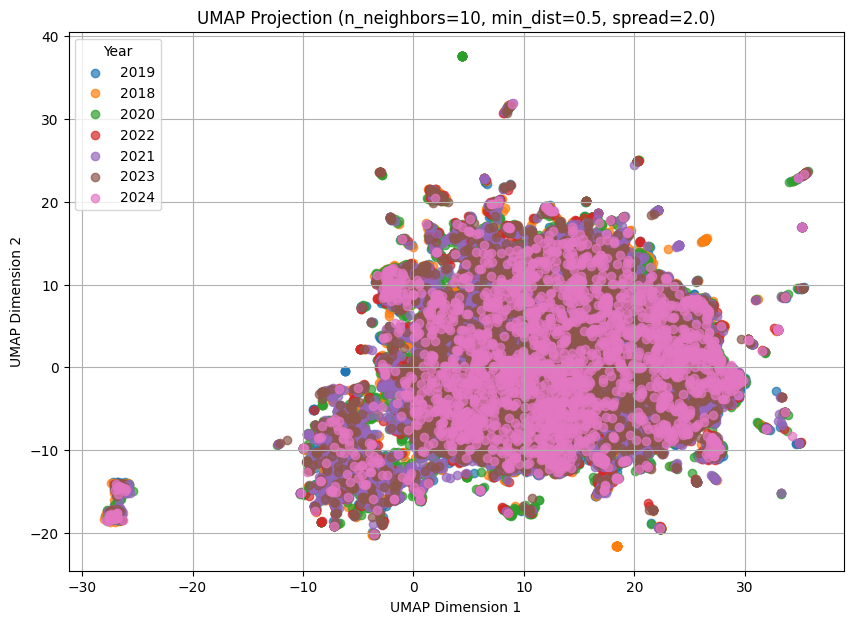

In [72]:
umap_df = umap_parameters(
    embeddings=sentence_embeddings_p,
    data=processing,
    n_neighbors=10,          # Decrease for localized structure
    min_dist=0.5,            # Increase for dispersed clusters
    spread=2.0,              # Increase scale of the visualization
    repulsion_strength=2.0,  # Push points apart more strongly
    learning_rate=5.0,       # Adapt embedding faster
    metric='cosine',         # Use cosine metric for text embeddings
    densmap=False,           # Enable DensMAP if needed
    random_state=42          # Reproducibility
)

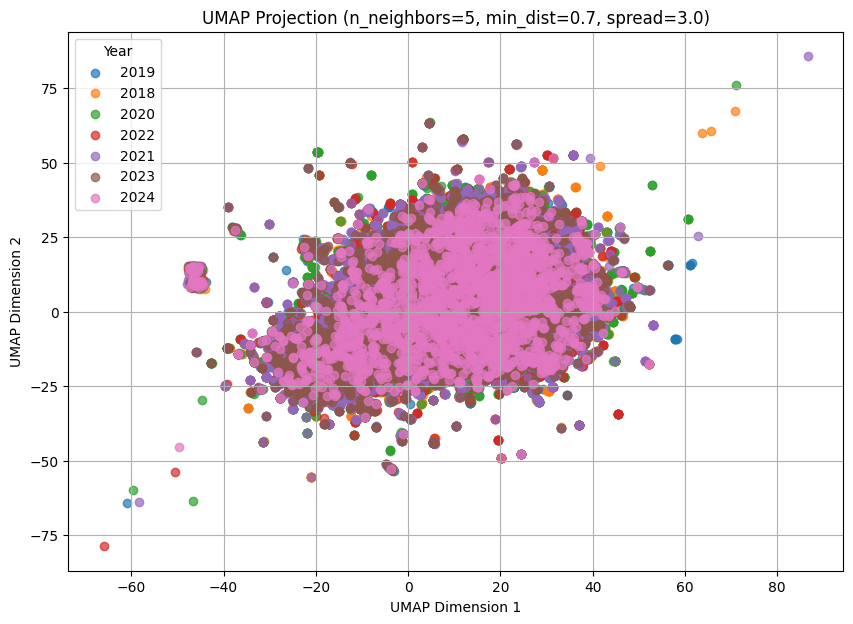

In [74]:
umap_df_2 = umap_parameters(
    embeddings=sentence_embeddings_p,
    data=processing,
    n_neighbors=5,          # Fewer neighbors to focus on local structure
    min_dist=0.7,           # Higher to prevent tight clustering
    spread=3.0,             # Increase scale for maximum spread
    repulsion_strength=3.0, # Stronger repulsion for more dispersion
    learning_rate=10.0,     # Faster adaptation
    metric='cosine',        # Use cosine for text embeddings
    densmap=False,           # Enable DensMAP for density adjustments
    random_state=42         # Reproducibility
)

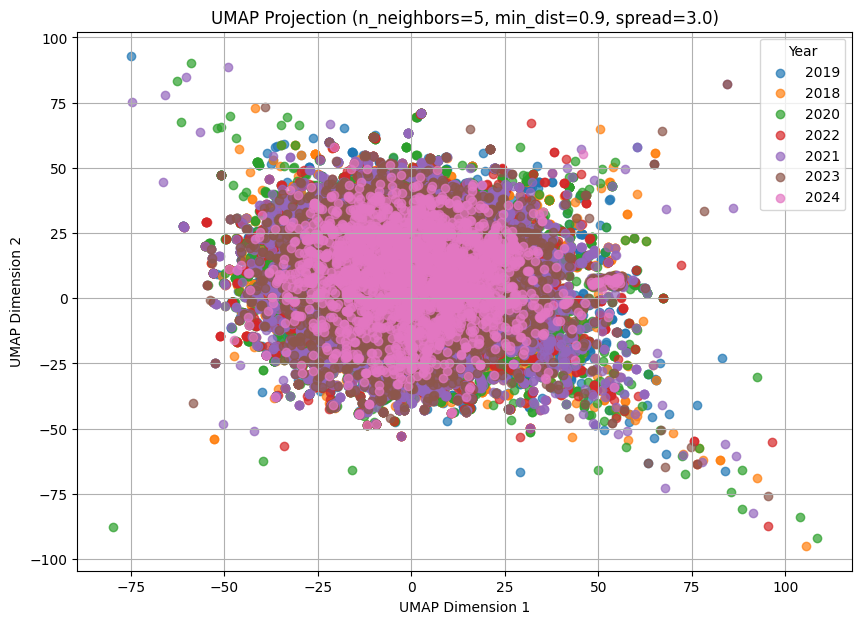

In [38]:
umap_df_3 = umap_parameters(
    embeddings=sentence_embeddings_p,
    data=processing,
    n_neighbors=5,          # Fewer neighbors to focus on local structure
    min_dist=0.9,           # Higher to prevent tight clustering
    spread=3.0,             # Increase scale for maximum spread
    repulsion_strength=4.0, # Stronger repulsion for more dispersion
    learning_rate=10.0,     # Faster adaptation
    metric='cosine',        # Use cosine for text embeddings
    densmap=False,          # Enable DensMAP for density adjustments
    set_op_mix_ratio=0.5,   # Lower value to focus more on local neighbors
    random_state=42         # Reproducibility
)

### UMAP embedding visualization (sentence transformers)

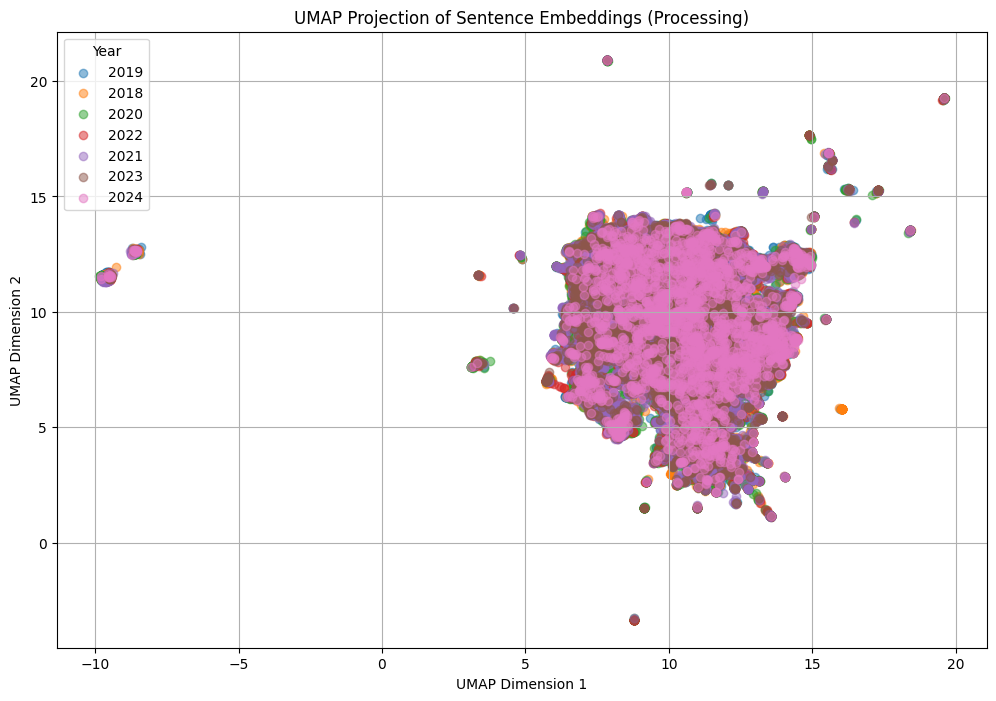

In [41]:
plt.figure(figsize=(12,8))
unique_years = umap_df_p['year'].unique()
for year in unique_years:
    subset = umap_df_p[umap_df_p['year'] == year]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(year), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Processing)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Year')
plt.grid()
plt.show()

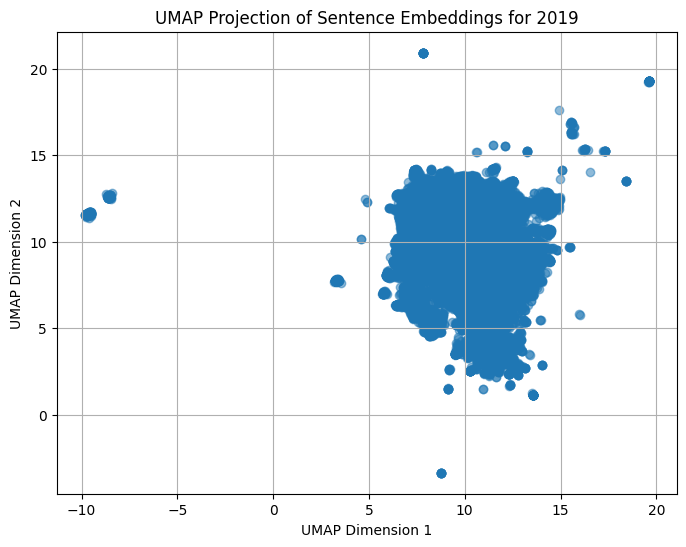

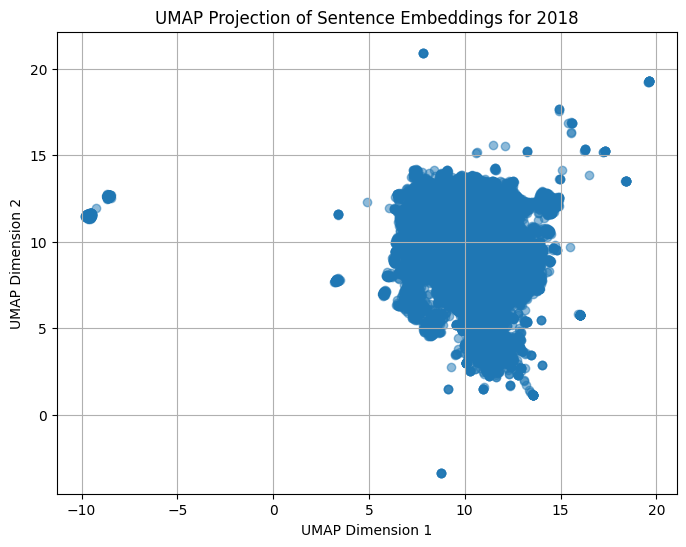

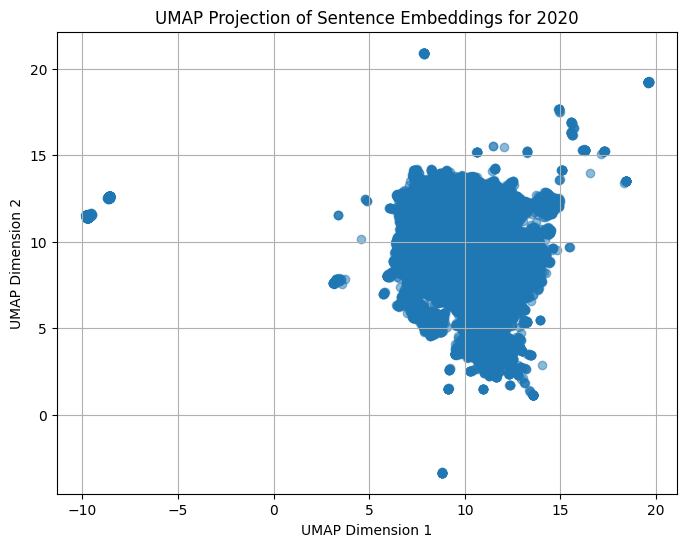

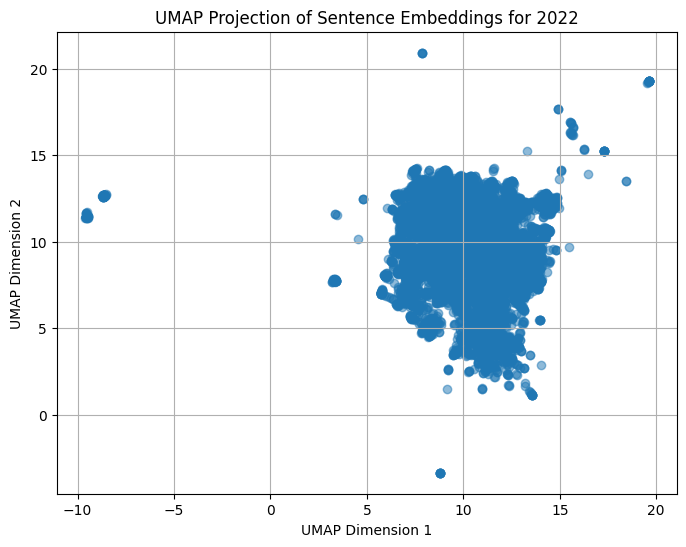

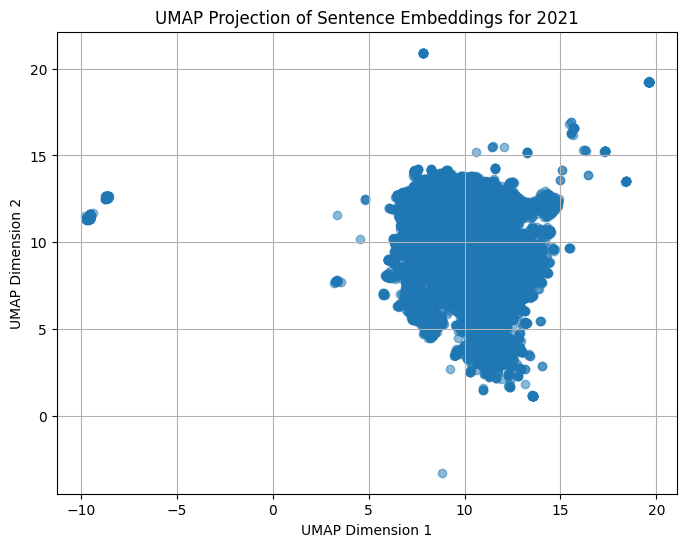

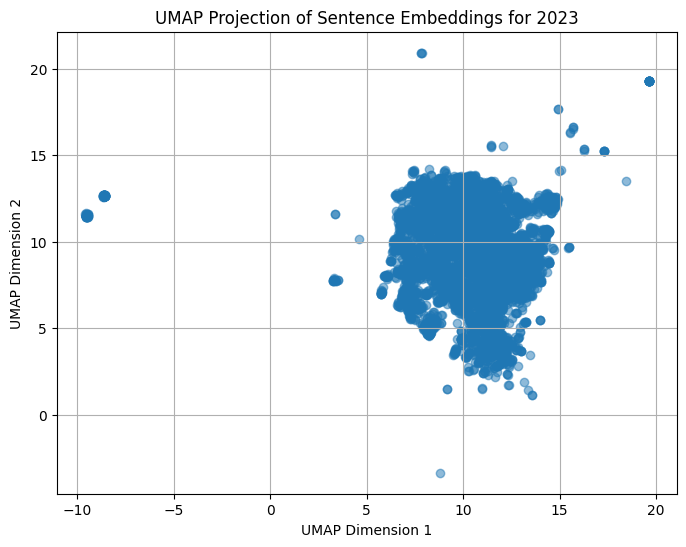

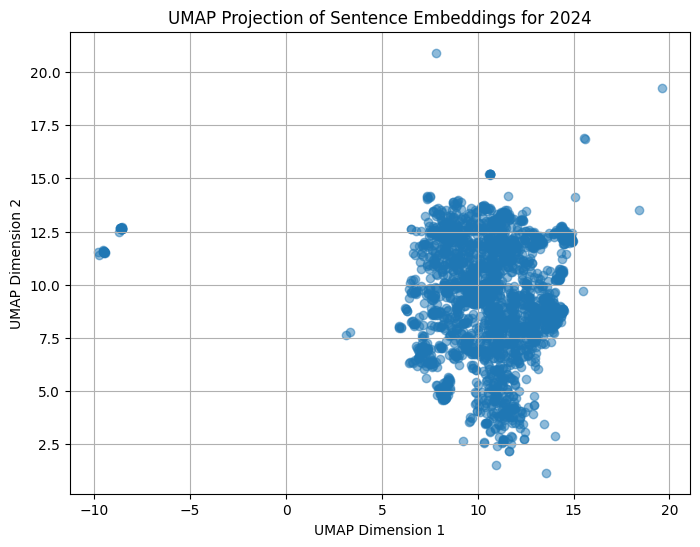

In [42]:
for year in unique_years:
    subset = umap_df_p[umap_df_p['year'] == year]

    plt.figure(figsize=(8,6))
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'], alpha=0.5)

    plt.title(f'UMAP Projection of Sentence Embeddings for {year}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid()
    plt.show()

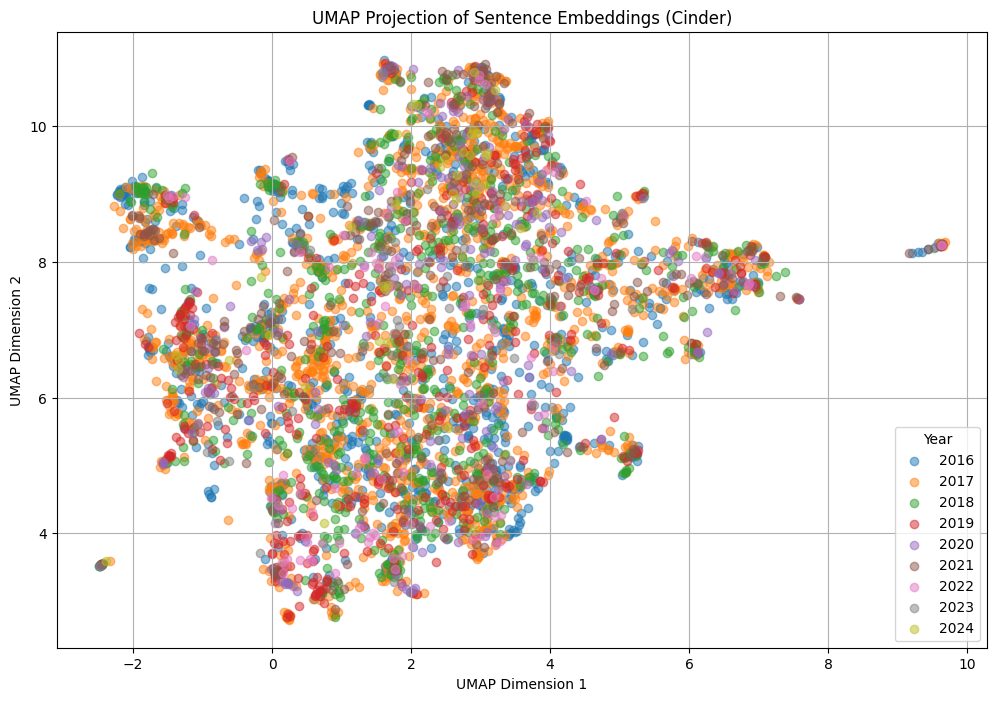

In [43]:
plt.figure(figsize=(12,8))
unique_years_c = umap_df_c['year'].unique()
for year in unique_years_c:
    subset = umap_df_c[umap_df_c['year'] == year]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(year), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Cinder)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Year')
plt.grid()
plt.show()

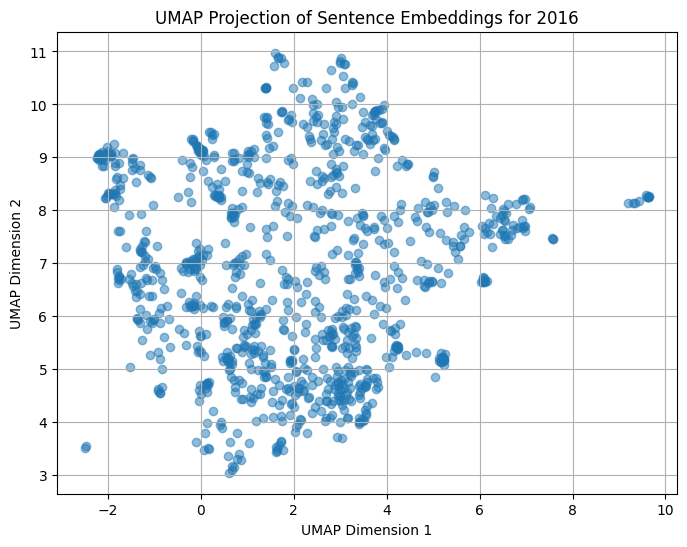

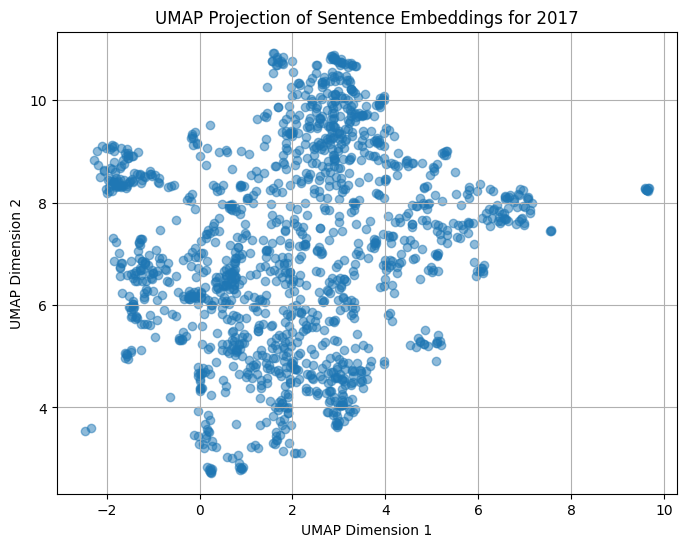

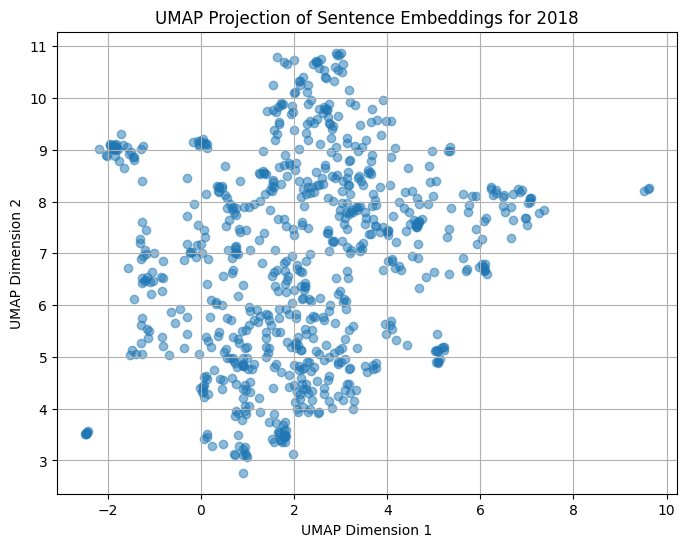

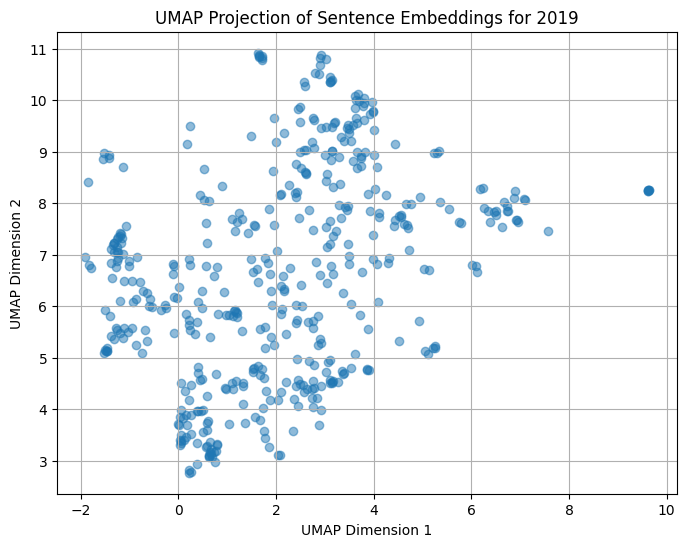

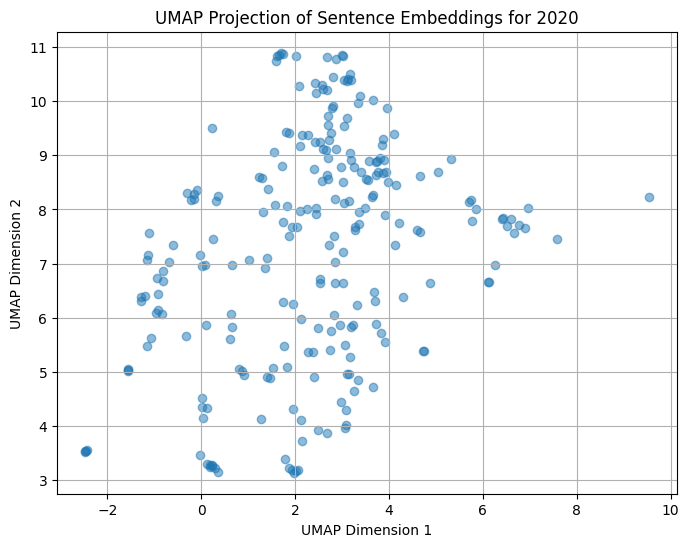

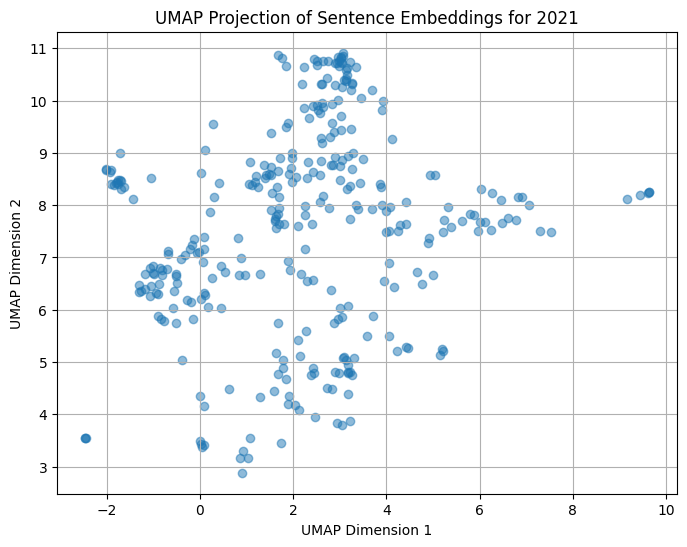

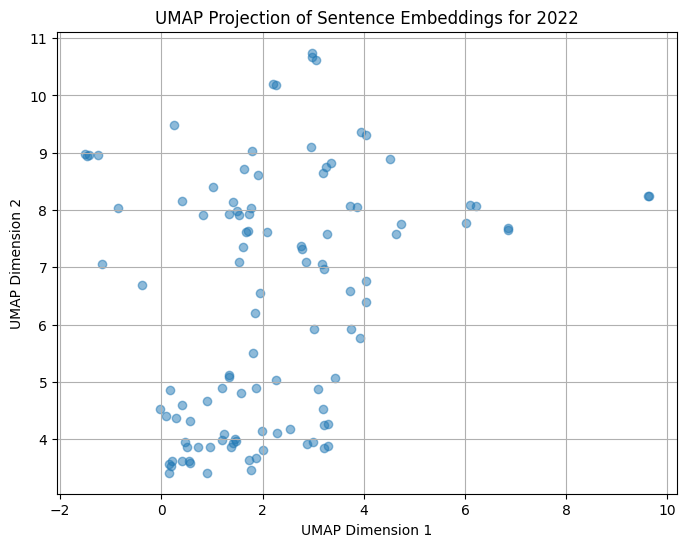

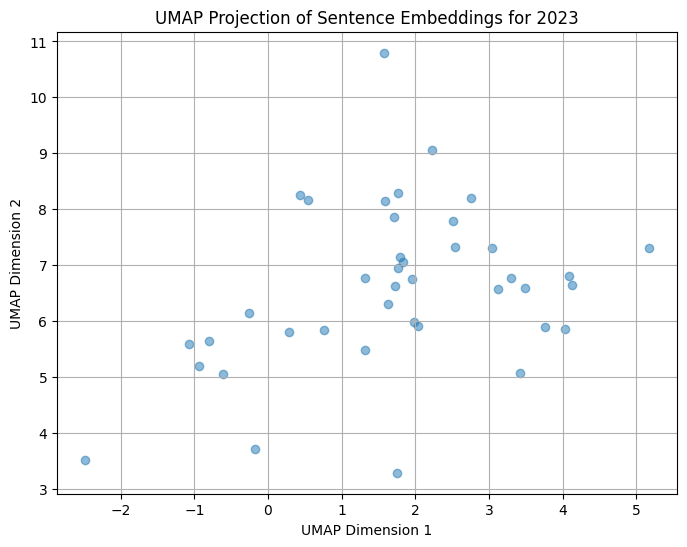

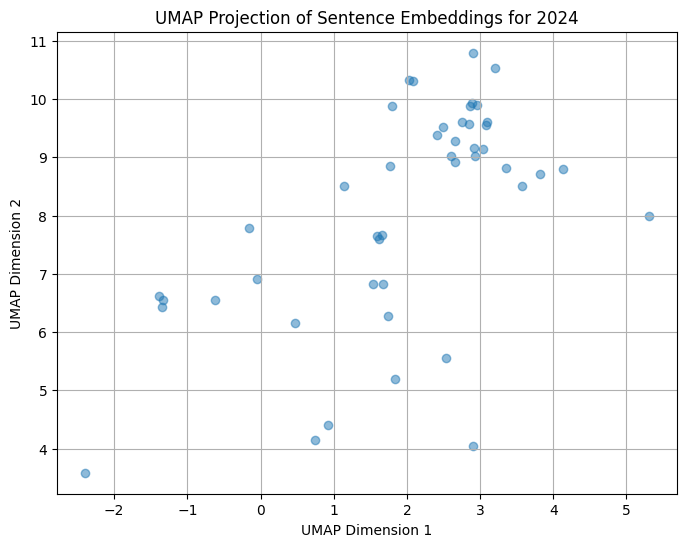

In [44]:
for year in unique_years_c:
    subset = umap_df_c[umap_df_c['year'] == year]

    plt.figure(figsize=(8,6))
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'], alpha=0.5)

    plt.title(f'UMAP Projection of Sentence Embeddings for {year}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid()
    plt.show()

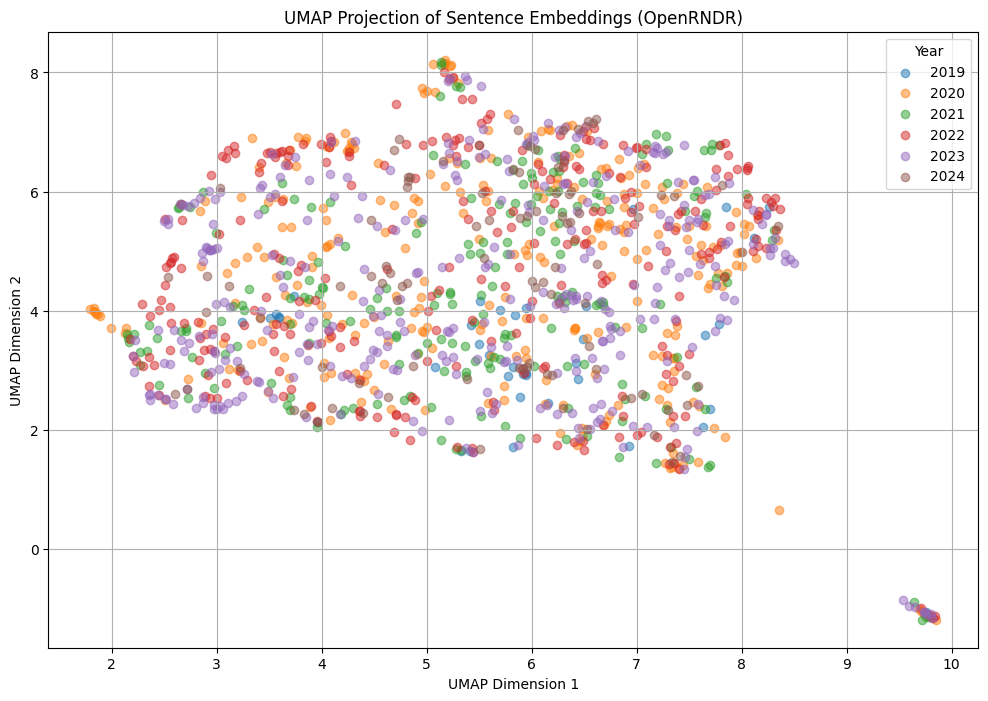

In [45]:
plt.figure(figsize=(12,8))
unique_years_o = umap_df_o['year'].unique()
for year in unique_years_o:
    subset = umap_df_o[umap_df_o['year'] == year]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(year), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (OpenRNDR)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Year')
plt.grid()
plt.show()

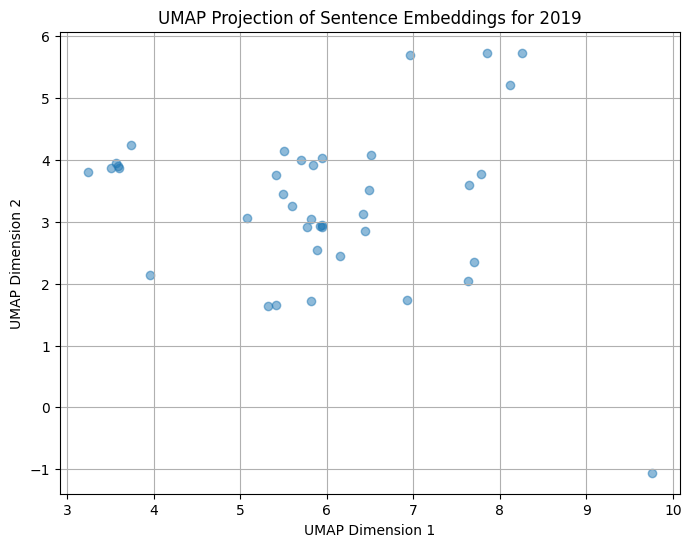

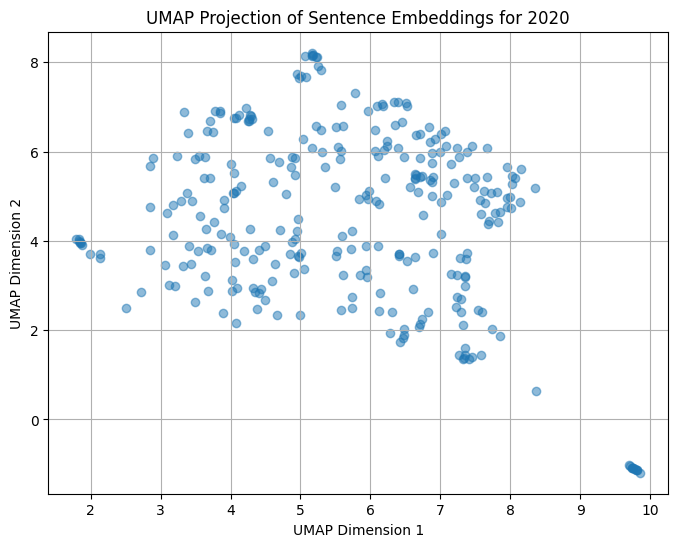

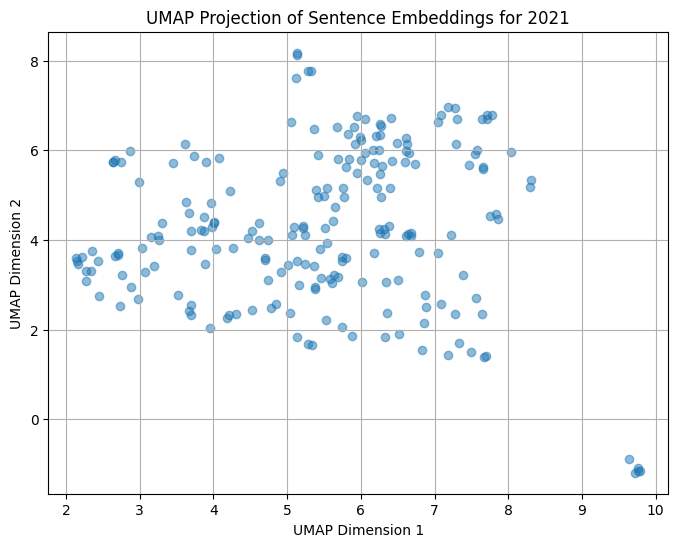

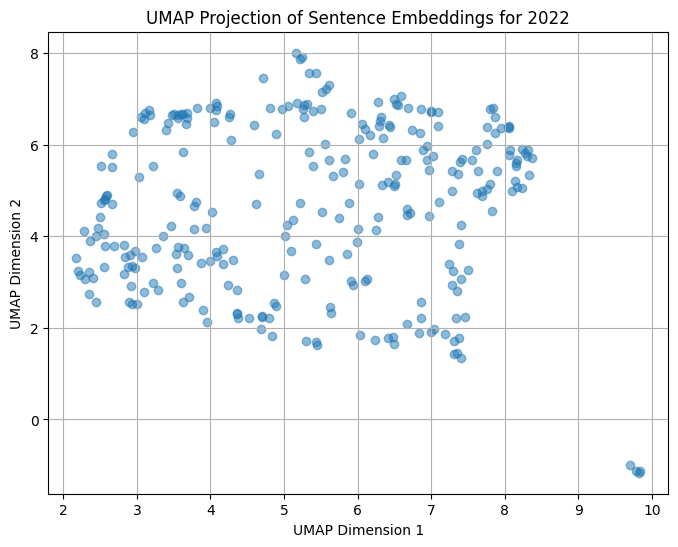

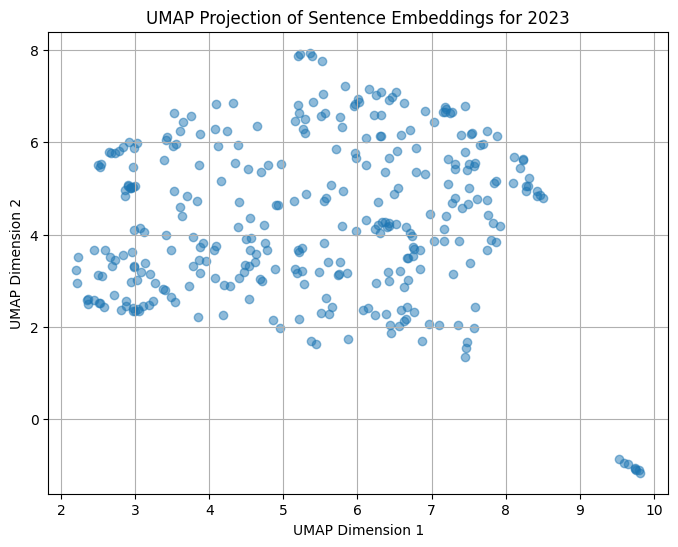

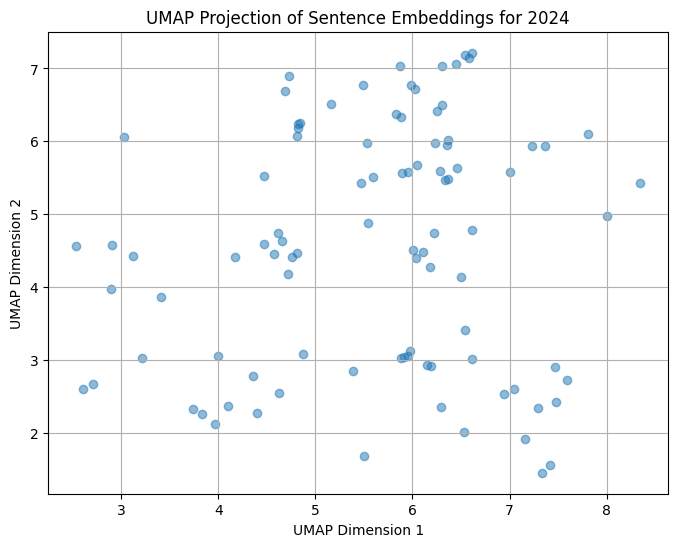

In [46]:
for year in unique_years_o:
    subset = umap_df_o[umap_df_o['year'] == year]

    plt.figure(figsize=(8,6))
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'], alpha=0.5)

    plt.title(f'UMAP Projection of Sentence Embeddings for {year}')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid()
    plt.show()

#### HDBSCAN Clustering

In [255]:
# continuation after creating UMAP embeddings

def apply_hdbscan(umap_embeddings, min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='eom', allow_single_cluster=False):
    """
    applies HDBSCAN clustering to precomputed UMAP embeddings

    parameters:
    - umap_embeddings: the precomputed UMAP embeddings (2D array)
    - min_cluster_size: minimum size of clusters 
    - min_samples: minimum number of samples for each cluster
    - metric: distance metric to use
    - cluster_selection_method: method for cluster selection

    returns:
    - cluster_labels: array of cluster labels for each data point
    """

    # initialize HDBSCAN model
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric=metric,
        cluster_selection_method=cluster_selection_method,
        allow_single_cluster=allow_single_cluster,
        prediction_data=False
    )

    # fit the model to the UMAP embeddings and return cluster labels
    cluster_labels = hdbscan_model.fit_predict(umap_embeddings)

    return hdbscan_model, cluster_labels

In [260]:
#hdbscan_cluster_p = apply_hdbscan(umap_sentence_emb_p)
hdbscan_model_c, hdbscan_cluster_c = apply_hdbscan(umap_cinder, min_cluster_size=60, min_samples=5)
hdbscan_model_o, hdbscan_cluster_o = apply_hdbscan(umap_openrndr)

In [261]:
cinder['hdbscan cluster'] = hdbscan_cluster_c
openrndr['hdbscan cluster'] = hdbscan_cluster_o

In [262]:
unique_clusters_c = sorted(cinder['hdbscan cluster'].unique())
unique_clusters_o = sorted(openrndr['hdbscan cluster'].unique())

palette_c = sns.color_palette("tab20", len(unique_clusters_c))
palette_o = sns.color_palette("tab20", len(unique_clusters_o))

# Map cluster labels to colors
color_mapping_c = {cluster: palette_c[i] for i, cluster in enumerate(unique_clusters_c) if cluster != -1}
color_mapping_o = {cluster: palette_o[i] for i, cluster in enumerate(unique_clusters_o) if cluster != -1}
color_mapping_c[-1] = 'gray'  # Assign gray for noise points
color_mapping_o[-1] = 'gray'


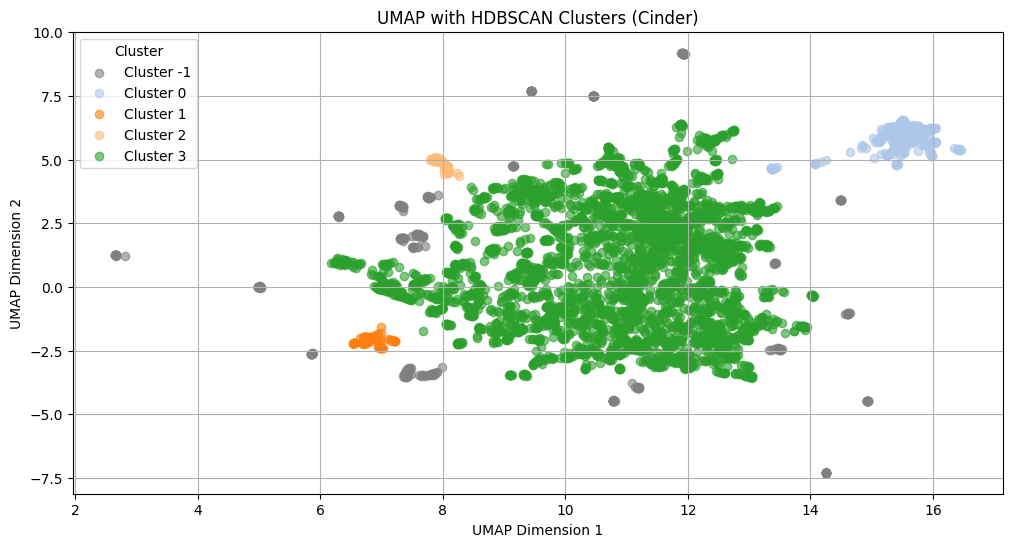

In [263]:
# Plot Cinder UMAP with HDBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster in unique_clusters_c:
    subset = cinder[cinder['hdbscan cluster'] == cluster]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=f'Cluster {cluster}', alpha=0.6, color=color_mapping_c[cluster])
plt.title('UMAP with HDBSCAN Clusters (Cinder)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

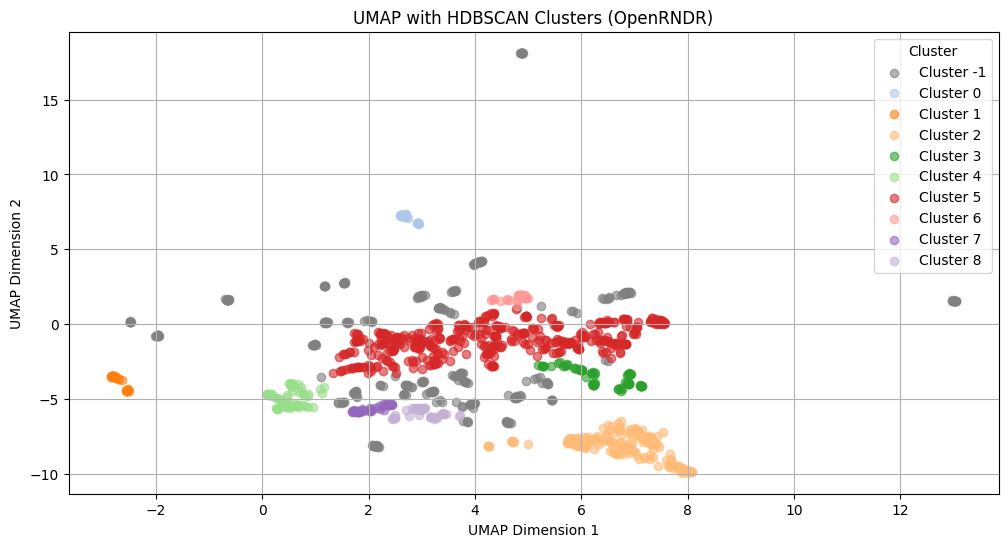

In [264]:
# Plot OpenRNDR UMAP with HDBSCAN clusters
plt.figure(figsize=(12, 6))
for cluster in unique_clusters_o:
    subset = openrndr[openrndr['hdbscan cluster'] == cluster]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=f'Cluster {cluster}', alpha=0.6, color=color_mapping_o[cluster])
plt.title('UMAP with HDBSCAN Clusters (OpenRNDR)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend(title='Cluster')
plt.grid()
plt.show()

#### BerTOPIC

In [ ]:
# cooked_html_cleaned

In [ ]:
def apply_topic_model(documents, n_neighbors=15, min_dist=0.1, n_components=2, min_cluster_size=30, min_samples=5, random_state=42):
    """
    applies UMAP, HDBSCAN, and Representation model to the documents

    returns:
    topics (list): topics assigned to each document
    probs (list): probabilities of the topics assigned to each document
    """
    umap_model = UMAP(
        metric='cosine', 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        n_components=n_components,
        random_state=random_state
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=False
    )

    keybert = KeyBERTInspired()
    mmr = MaximalMarginalRelevance(diversity=0.5)

    representation_model = {"KeyBERT": keybert, "MMR": mmr}
    
    topic_model = BERTopic(
        embedding_model=model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        
        calculate_probabilities=False,
        top_n_words=15,
        nr_topics='auto',
        verbose=True)
    
    topics, probs = topic_model.fit_transform(documents)

    return topic_model, topics, probs

In [266]:
def apply_topic_model_2(df, n_neighbors=15, min_dist=0.1, n_components=2, min_cluster_size=30, min_samples=5, random_state=42):
    
    df['topic_slug'] = df['topic_slug'].str.replace('-', ' ')
    text = [
        row['topic_slug'] + tokenizer.sep_token + (row['processed_text'] or '') # was originally cooked_html_cleaned
        for _, row in df.iterrows()
    ]

    umap_model = UMAP(
        metric='cosine', 
        n_neighbors=n_neighbors, 
        min_dist=min_dist, 
        n_components=n_components,
        random_state=random_state
    )

    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        metric='euclidean',
        cluster_selection_method='eom',
        prediction_data=False
    )

    keybert = KeyBERTInspired()
    mmr = MaximalMarginalRelevance(diversity=0.5)

    representation_model = {"KeyBERT": keybert, "MMR": mmr}
    
    topic_model = BERTopic(
        embedding_model=specter2,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        representation_model=representation_model,
        
        calculate_probabilities=False,
        top_n_words=15,
        nr_topics='auto',
        verbose=True)
    
    topics, probs = topic_model.fit_transform(text)

    return topic_model, topics, probs

In [57]:
topic_model_p, topics_p, probs_p = apply_topic_model(processing['processed_text'], n_neighbors=15, n_components=2, min_cluster_size=80, min_samples=20)

2024-11-24 13:24:49,901 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/2984 [00:00<?, ?it/s]

2024-11-24 14:43:33,578 - BERTopic - Embedding - Completed ✓
2024-11-24 14:43:33,585 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-11-24 14:51:41,685 - BERTopic - Dimensionality - Completed ✓
2024-11-24 14:51:41,697 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-11-24 14:51:47,420 - BERTopic - Cluster - Completed ✓
2024-11-24 14:51:47,423 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-11-24 14:53:16,162 - BERTopic - Representation - Completed ✓
2024-11-24 14:53:16,165 - BERTopic - Topic reduction - Reducing number of topics
2024-11-24 14:54:13,112 - BERTopic - Topic reduction - Reduced number of topics from 125 to 77


In [270]:
topic_model_c, topics_c, probs_c = apply_topic_model(cinder['processed_text'], n_neighbors=15, n_components=2, min_cluster_size=50, min_samples=5) 

2024-12-09 16:25:40,996 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/140 [00:00<?, ?it/s]

2024-12-09 16:26:22,912 - BERTopic - Embedding - Completed ✓
2024-12-09 16:26:22,925 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-09 16:26:30,477 - BERTopic - Dimensionality - Completed ✓
2024-12-09 16:26:30,477 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-09 16:26:30,593 - BERTopic - Cluster - Completed ✓
2024-12-09 16:26:30,593 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-09 16:26:33,488 - BERTopic - Representation - Completed ✓
2024-12-09 16:26:33,488 - BERTopic - Topic reduction - Reducing number of topics
2024-12-09 16:26:36,325 - BERTopic - Topic reduction - Reduced number of topics from 9 to 9


In [271]:
topic_model_o, topics_o, probs_o = apply_topic_model(openrndr['processed_text'])

2024-12-09 16:26:36,677 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2024-12-09 16:26:45,984 - BERTopic - Embedding - Completed ✓
2024-12-09 16:26:45,984 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-09 16:26:49,835 - BERTopic - Dimensionality - Completed ✓
2024-12-09 16:26:49,835 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-09 16:26:49,872 - BERTopic - Cluster - Completed ✓
2024-12-09 16:26:49,873 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-09 16:26:52,161 - BERTopic - Representation - Completed ✓
2024-12-09 16:26:52,161 - BERTopic - Topic reduction - Reducing number of topics
2024-12-09 16:26:54,331 - BERTopic - Topic reduction - Reduced number of topics from 6 to 6


In [272]:
topic_model_o.get_topic_info()

Topic  Count                               Name  \
0     -1    181     -1_text_openrndr_slack_program   
1      0    898         0_openrndr_code_use_kotlin   
2      1     57        1_video_ffmpeg_frame_frames   
3      2     54  2_thank_awesome_appreciate_thanks   
4      3     34          3_nvidia_graphics_gpu_amd   
5      4     31      4_welcome_forum_category_post   

                                      Representation  \
0  [text, openrndr, slack, program, use, hi, font...   
1  [openrndr, code, use, kotlin, program, time, w...   
2  [video, ffmpeg, frame, frames, mouse, cpu, rat...   
3  [thank, awesome, appreciate, thanks, maybe, fi...   
4  [nvidia, graphics, gpu, amd, card, windows, ma...   
5  [welcome, forum, category, post, hi, details, ...   

                                             KeyBERT  \
0  [fonts, drawing, glyphs, text, phidgets, sketc...   
1  [openrndr, build, java, projects, programs, co...   
2  [ffmpeg, videos, fps, screen, frames, resoluti...   
3  [thanks, appreciate, thank, awesome, posting, ...   
4  [nvidia, gpu, crashes, amd, crashing, graphics...   
5  [forum, welcome, feedback, welcoming, create, ...   

                                                 MMR  \
0  [openrndr, slack, hi, font, characters, code, ...   
1  [openrndr, code, kotlin, processing, orx, proj...   
2  [ffmpeg, frames, mouse, cpu, fps, try, format,...   
3  [appreciate, try, link, tip, composite, olive,...   
4  [gpu, drivers, try, intel, virtual, settings, ...   
5  [welcome, forum, category, post, feedback, cre...   

                                 Representative_Docs  
0  [performance reasons load font creates texture...  
1  [Hi forum super busy mean things moving OPENRN...  
2  [video wanted add details screen reporting tho...  
3  [Hey reaching appreciate checking work pretty ...  
4  [Hi Edwin quick answer Sadly computer laptop s...  
5  [Welcome forum write, Hi Welcome forum details...

In [273]:
topic_model_c.get_topic_info()

Topic  Count                             Name  \
0     -1    468       -1_cinder_thanks_touch_use   
1      0   1511      0_shader_texture_use_opengl   
2      1   1480     1_cinder_build_project_cmake   
3      2    296  2_video_gstreamer_cinder_player   
4      3    282        3_thanks_thank_great_help   
5      4    193      4_audio_device_input_output   
6      5     95        5_font_text_sdf_character   
7      6     71        6_udp_thread_tcp_messages   
8      7     65       7_frame_vertical_sync_rate   

                                      Representation  \
0  [cinder, thanks, touch, use, time, way, code, ...   
1  [shader, texture, use, opengl, cinder, draw, c...   
2  [cinder, build, project, cmake, app, use, file...   
3  [video, gstreamer, cinder, player, videos, pla...   
4  [thanks, thank, great, help, petros, hi, cheer...   
5  [audio, device, input, output, midi, channels,...   
6  [font, text, sdf, character, fonts, size, char...   
7  [udp, thread, tcp, messages, server, connectio...   
8  [frame, vertical, sync, rate, fps, disable, vs...   

                                             KeyBERT  \
0  [cinder, screen, windows, application, draw, b...   
1  [shader, opengl, shaders, textures, texture, g...   
2  [cinder, build, cmake, compile, building, comp...   
3  [gstreamer, playback, videos, quicktime, video...   
4  [thanks, thank, cheers, glad, appreciate, link...   
5  [audio, portaudio, pulseaudio, playback, stere...   
6  [fonts, font, sdf, texturefont, text, sdftext,...   
7  [udp, tcp, multicast, multicasting, socket, pa...   
8  [framerate, nvidia, fps, stuttering, flickerin...   

                                                 MMR  \
0  [cinder, thanks, vulkan, file, hi, camera, pro...   
1  [shader, texture, opengl, cinder, draw, fbo, n...   
2  [cinder, build, cmake, file, include, try, boo...   
3  [video, gstreamer, playback, frames, quicktime...   
4  [petros, hey, appreciate, andrew, gabor, worke...   
5  [audio, midi, cinder, node, file, fft, asio, f...   
6  [sdf, fonts, glyphs, cinder, spaces, looks, xm...   
7  [udp, message, signals, case, port, osc, midi,...   
8  [vertical, disable, vsync, framerate, mouse, s...   

                                 Representative_Docs  
0  [Hey response misunderstanding response poor j...  
1  [good idea mind moving forward reading gathere...  
2  [building application find Cinder build Cinder...  
3  [Hi Patrick basic GStreamer player functionali...  
4                           [Thanks, Thanks, Thanks]  
5  [figure driver settings access channels sure c...  
6  [Thanks great feedback ways primary intent VR ...  
7  [Hi working Master Slave functionality block r...  
8  [Good hear found problem researched NVIDIA dri...

In [62]:
topic_model_p.get_topic_info()

Topic  Count                                               Name  \
0      -1  41152                       -1_code_draw_want_processing   
1       0  12287                        0_image_draw_mouse_function   
2       1   5182                      1_folder_java_processing_file   
3       2   2887                                2_pjs_js_editor_web   
4       3   2879                           3_sound_audio_minim_play   
..    ...    ...                                                ...   
72     71     85            71_function_semicolon_method_semicolons   
73     72     84                   72_sense_makes_nevermind_figured   
74     73     83                    73_framecount_frame_frames_size   
75     74     82  74_library_augustoestgazetrack_eyetrackers_gaz...   
76     75     82            75_clear_explanation_explain_understand   

                                       Representation  \
0   [code, draw, want, processing, make, function,...   
1   [image, draw, mouse, function, want, code, bal...   
2   [folder, java, processing, file, pde, files, r...   
3   [pjs, js, editor, web, javascript, html, index...   
4   [sound, audio, minim, play, library, fft, midi...   
..                                                ...   
72  [function, semicolon, method, semicolons, hey,...   
73  [sense, makes, nevermind, figured, ohhh, oh, b...   
74  [framecount, frame, frames, size, text, fc, se...   
75  [library, augustoestgazetrack, eyetrackers, ga...   
76  [clear, explanation, explain, understand, clar...   

                                              KeyBERT  \
0   [code, program, java, drawing, processing, ske...   
1   [rectangle, drawing, grid, screen, code, draw,...   
2   [folder, files, folders, file, directory, java...   
3   [sketchjs, pjs, nodejs, processingjs, javascri...   
4   [soundfile, audio, psoundjs, playback, audiosa...   
..                                                ...   
72  [function, functions, functionality, method, e...   
73  [sense, silly, idk, odd, figured, explains, du...   
74  [framecount, frames, frame, counter, code, scr...   
75  [library, libraries, librarywrangling, kindle,...   
76  [clear, clearing, clearer, clearify, unclear, ...   

                                                  MMR  \
0   [draw, processing, function, sketch, image, pr...   
1   [draw, mouse, function, code, ball, circle, sc...   
2   [java, pde, sketch, ide, install, directory, e...   
3   [pjs, js, editor, indexhtml, browser, clientsi...   
4   [minim, play, fft, midi, frequency, code, tria...   
..                                                ...   
72  [function, semicolons, varx, brackets, blomer,...   
73  [whirl, dunno, ahhhhhh, sensethanks, anyhting,...   
74  [framecount, text, settings, blurry, largest, ...   
75  [eyetrackers, gazetrack, enables, libraries, r...   
76  [didnt, notice, rabbit, clearer, hole, cristal...   

                                  Representative_Docs  
0   [hey believe problem hit key appear second rig...  
1   [pretty new processing need make game battlesh...  
2   [sure tag yeah project want friend doesnt proc...  
3   [web editor pjs javascript library goal making...  
4   [sound library issue processing android runnin...  
..                                                ...  
72                [need function, function, function]  
73            [makes sense, makes sense, makes sense]  
74  [remembered similar thread maybe help differen...  
75                      [library, library, p library]  
76       [clear, didnt make clear, explanation clear]  

[77 rows x 7 columns]

### visualizing topics

In [127]:
#processing['generated_topic'] = topics_p
cinder['generated_topic'] = topics_c
openrndr['generated_topic'] = topics_o

In [ ]:
plt.figure(figsize=(12,8))
unique_topics = processing['generated_topic'].unique()
for topic in unique_topics:
    subset = processing[processing['generated_topic'] == topic]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(topic), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Processing)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Topic')
plt.grid()
plt.show()

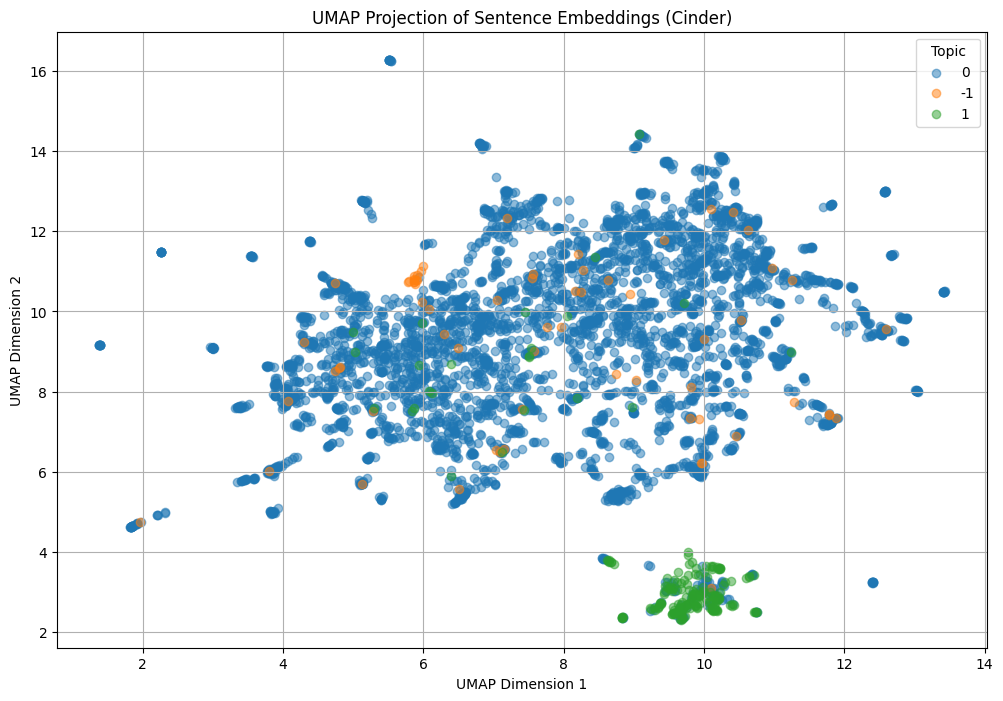

In [128]:
plt.figure(figsize=(12,8))
unique_topics_c = cinder['generated_topic'].unique()
for topic in unique_topics_c:
    subset = cinder[cinder['generated_topic'] == topic]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(topic), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (Cinder)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Topic')
plt.grid()
plt.show()

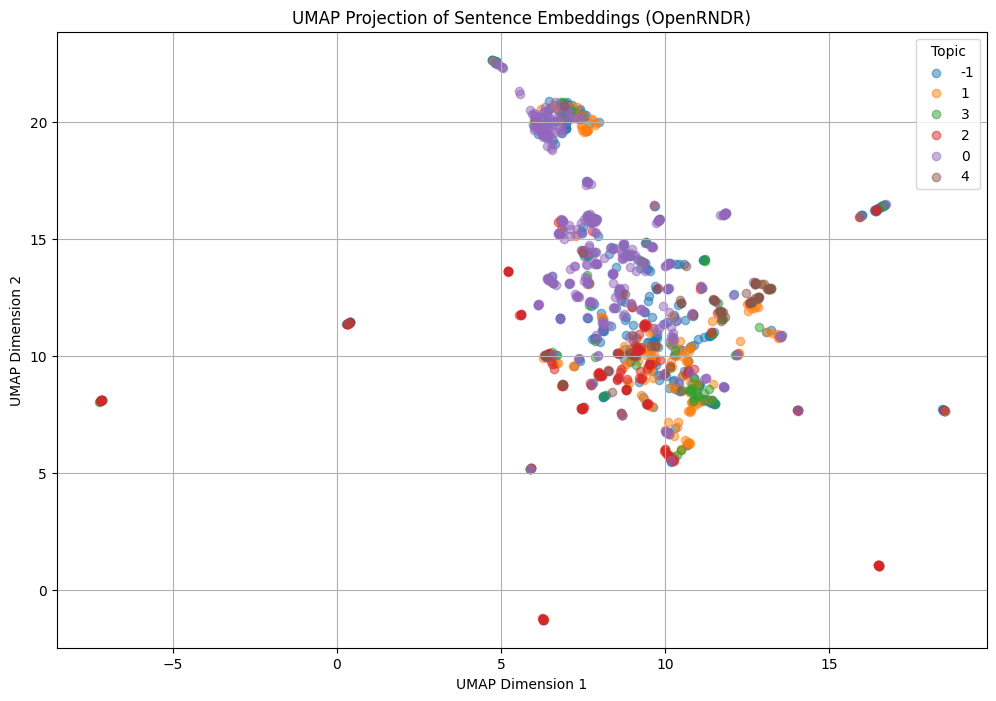

In [129]:
plt.figure(figsize=(12,8))
unique_topics_o = openrndr['generated_topic'].unique()
for topic in unique_topics_o:
    subset = openrndr[openrndr['generated_topic'] == topic]
    plt.scatter(subset['UMAP Dimension 1'], subset['UMAP Dimension 2'],
                label=str(topic), alpha=0.5)

plt.title('UMAP Projection of Sentence Embeddings (OpenRNDR)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')

plt.legend(title='Topic')
plt.grid()
plt.show()